## I. Selenium


### 1. Import và cài đặt các thư viện cần thiết

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains, ScrollOrigin
import pandas as pd
from time import sleep
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
import seaborn as sns
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import re


In [64]:
plt.style.use('ggplot')

### 2. Thực hiện cào dữ liệu từ web

In [ ]:

# Khởi tạo ChromeOptions
options = webdriver.ChromeOptions()
options.add_argument("--disable-blink-features=AutomationControlled")
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)
# options.add_argument("--headless")  # Bỏ comment nếu muốn chạy nền
# Đường dẫn tới ChromeDriver
service = Service("C:/Users/ADMIN/.cache/selenium/chromedriver/win64/138.0.7204.94/chromedriver.exe")
driver = webdriver.Chrome(service=service, options=options)

# Xóa navigator.webdriver
driver.execute_cdp_cmd("Page.addScriptToEvaluateOnNewDocument", {
    "source": """
        Object.defineProperty(navigator, 'webdriver', {
            get: () => undefined
        })
    """
})
# base_url='https://batdongsan.com.vn/nha-dat-ban-tp-hcm'
# base_url='https://batdongsan.com.vn/nha-dat-ban-tp-hcm/gia-tu-10-ty-den-20-ty'
base_url='https://batdongsan.com.vn/ban-dat-nen-du-an-tp-hcm'
# driver.get(url)

def get_item_info(item):
    info = {}
    try:
        info['title']=item.find_element(By.CLASS_NAME,'js__card-title').text
    except:
        info['title']=np.nan
    try:
        info['price'] = item.find_element(By.CLASS_NAME, 're__card-config-price').text
    except:
        info['price'] =np.nan

    try:
        info['square'] = item.find_element(By.CLASS_NAME, 're__card-config-area').text
    except:
        info['square'] = np.nan

    try:
        info['price_per_square'] = item.find_element(By.CLASS_NAME, 're__card-config-price_per_m2').text
    except:
        info['price_per_square'] = np.nan

    try:
        info['bedroom'] = item.find_element(By.CLASS_NAME, 're__card-config-bedroom').text
    except:
        info['bedroom'] = np.nan

    try:
        info['wc'] = item.find_element(By.CLASS_NAME, 're__card-config-toilet').text
    except:
        info['wc'] = np.nan
    try:
        info['location']=item.find_element(By.CLASS_NAME,'re__card-location').text
    except:
        info['location']=np.nan

    return info
def get_coordinates_from_url(driver):
    """Lấy lat/lon từ iframe Google Maps trong trang chi tiết"""
    lat, lon = None, None
    try:
        iframes = driver.find_elements(By.TAG_NAME, "iframe")
        for iframe in iframes:
            src = iframe.get_attribute("data-src") or iframe.get_attribute("src")
            if src and "google.com/maps/embed/v1/place" in src:
                match = re.search(r"q=(-?\d+\.\d+),(-?\d+\.\d+)", src)
                if match:
                    lat = float(match.group(1))
                    lon = float(match.group(2))
                    break
    except Exception as e:
        print("❌ Không lấy được tọa độ:", e)
    return lat, lon
def get_housetype_and_map(item, timeout=10):
    FEATURES = ["Hướng nhà","Pháp lý", "Nội thất","Mặt tiền","Đường vào","Số tầng"]

    try:
        item.click()
        time.sleep(5)
    except Exception as e:
        print("❌ Không click được vào item:", e)
        return {}

    while True:
        try:
            data = {}

            # ---- Lấy loại nhà ----
            try:
                housetype = driver.find_element(By.XPATH, '//a[@level="4"]').text
                data["Loại nhà"] = housetype
            except:
                pass

            # ---- Lấy đặc điểm bất động sản ----
            try:
                items = driver.find_elements(By.CLASS_NAME, "re__pr-specs-content-item")
                for block in items:
                    try:
                        label = block.find_element(By.CLASS_NAME, "re__pr-specs-content-item-title").text.strip()
                        value = block.find_element(By.CLASS_NAME, "re__pr-specs-content-item-value").text.strip()
                        if label in FEATURES:
                            data[label] = value
                    except:
                        pass
            except:
                pass
            lat, lon = get_coordinates_from_url(driver)
            data["Lat"] = lat
            data["Lon"] = lon
            driver.back()
            return data  # chỉ trả dict có dữ liệu thực sự
        except Exception as e:
            print("⚠️ CAPTCHA hoặc lỗi tải trang:", e)
            input("👉 Vui lòng xác minh CAPTCHA thủ công rồi nhấn Enter để tiếp tục...")


sleep(5)
    
results = []
for p in range(1, 35):
    if p == 1:
        url = base_url
    else:
        url = f'{base_url}/p{p}'

    driver.get(url)
    print(f"📄 Đang xử lý trang {p}...")
    time.sleep(5)

    # Chờ xác minh CAPTCHA nếu bị chặn
    while True:
        try:
            list_items = driver.find_element(By.CLASS_NAME, 'js__srp-list')
            items = list_items.find_elements(By.CLASS_NAME, 'js__card-full-web')

            # Nếu danh sách item hợp lệ thì break để tiếp tục
            if len(items) > 0:
                print(f"✅ Tìm thấy {len(items)} tin đăng.")
                break
            else:
                raise Exception("Danh sách rỗng")
        except:
            print("⚠️ Có thể bị CAPTCHA hoặc lỗi tải trang.")
            input("👉 Vui lòng xác minh CAPTCHA thủ công rồi nhấn Enter để tiếp tục...")
           
    current_url=driver.current_url 
    for i in range(len(items)):
         for t in range(5):
            try:
                # lấy lại danh sách item mỗi lần back
                list_items = driver.find_element(By.CLASS_NAME, 'js__srp-list')
                items = list_items.find_elements(By.CLASS_NAME, 'js__card-full-web')

                info = get_item_info(item=items[i])   # lấy info ngắn
                house_map_info = get_housetype_and_map(item=items[i])  # click vào -> lấy info chi tiết
                info.update(house_map_info)

                results.append(info)
                break
            except Exception as e:
                print("❌ Lỗi khi xử lý item:", e)
                driver.get(current_url)


### 3. Chuyển dữ liệu về Dataframe và lưu vô file excel

In [4]:
df=pd.DataFrame(results)
df.head()

,title,price,square,price_per_square,bedroom,wc,location,Loại nhà,Hướng nhà,Mặt tiền,Đường vào,Pháp lý,Lat,Lon
0,HOT. 2 NỀN MT LIÊN PHƯỜNG 30M CHỈ 115 TRIỆU/M2,"11,5 tỷ",100 m²,115 tr/m²,NaN,NaN,"·\nQuận 9, Hồ Chí Minh",Đất nền dự án tại The Sun City Minh Sơn,Bắc,5 m,30 m,Hợp đồng mua bán,10.804319,106.794624
1,TỔNG GIỎ HÀNG HOT - PHƯỚC LỘC - CẦN GIỜ - 01/09,"13,92 tỷ",480 m²,29 tr/m²,NaN,NaN,"·\nCần Giờ, Hồ Chí Minh",Đất nền dự án tại La Maison De Cần Giờ,Tây - Nam,28 m,22 m,Hợp đồng mua bán,10.410857,106.955296
2,"THÁNG 9/2025! BÁN NHIỀU NỀN THẾ KỈ 21, HUY HOÀ...","32,5 tỷ",160 m²,"203,12 tr/m²",NaN,NaN,"Quận 2, Hồ Chí Minh",Đất nền dự án tại Khu dân cư Thạnh Mỹ Lợi,Đông - Bắc,20 m,40 m,Sổ đỏ/ Sổ hồng,10.769824,106.767767
3,Chính chủ bán đất nền KĐT An Hạ Lotus vị trí đ...,"3,5 tỷ",100 m²,35 tr/m²,NaN,NaN,"Bình Chánh, Hồ Chí Minh",Đất nền dự án tại An Hạ Lotus,NaN,NaN,32 m,Có sổ.,10.814742,106.516368
4,"Bán đất KDC Nam Hùng Vương DT (4,5x22m) giá ch...","5,5 tỷ",100 m²,55 tr/m²,NaN,NaN,"Bình Tân, Hồ Chí Minh",Đất nền dự án tại KDC Nam Hùng Vương,NaN,"4,5 m",4 m,Sổ đỏ/ Sổ hồng,10.723042,106.610383


In [ ]:
df.to_excel('Data/z_Predit_House.xlsx',index=False)

### 4. Đọc dữ liều từ file excel

In [2]:
df_house=pd.read_excel('Data/z_Predit_House.xlsx')

In [3]:
df_house.shape

(9852, 16)

Dữ liệu bao gồm 9852 dòng và 16 cột.

# II. Khám phá dữ liệu

## 1. Tổng quan dữ liệu

### 1.1 Xem định dạng dữ liệu

In [4]:
df_house.shape


(9852, 16)

Ta thấy dữ liệu sau khi cào về có 9852 dòng và 16 cột

### 1.2. Tóm tắt thông tin tổng quan

In [5]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9852 entries, 0 to 9851
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             9852 non-null   object 
 1   price             9852 non-null   object 
 2   square            9783 non-null   object 
 3   price_per_square  9434 non-null   object 
 4   bedroom           5706 non-null   float64
 5   wc                5257 non-null   float64
 6   location          9783 non-null   object 
 7   Lat               8423 non-null   float64
 8   Lon               8423 non-null   float64
 9   Loại nhà          8425 non-null   object 
 10  Nội thất          3829 non-null   object 
 11  Hướng nhà         2547 non-null   object 
 12  Pháp lý           7038 non-null   object 
 13  Mặt tiền          3967 non-null   object 
 14  Số tầng           3394 non-null   object 
 15  Đường vào         3595 non-null   object 
dtypes: float64(4), object(12)
memory usage: 1.

#### Dựa vào việc tóm tắt thông tin tổng quan ta thấy được một số cột chứa giá trị thiếu:

-	Thiếu dữ liệu (missing values): Một số cột có nhiều giá trị thiếu, ví dụ:
-	bedroom, wc (còn khoảng 40% dữ liệu bị thiếu).
-	Nội thất, Hướng nhà, Pháp lý, Mặt tiền, Số tầng, Đường vào có nhiều giá trị thiếu → cần xử lý trước khi phân tích.
-	Dữ liệu chưa chuẩn hóa:
-	price, square, price_per_square đang ở dạng object (chuỗi) → cần làm sạch (loại bỏ ký tự, đổi sang số).
-	Dữ liệu vị trí: Có tọa độ Lat, Lon → có thể khai thác để phân tích không gian (bản đồ, khoảng cách, phân cụm theo vị trí).
-	Loại dữ liệu hỗn hợp: Nhiều cột mang tính chất phân loại (categorical), ví dụ Loại nhà, Hướng nhà, Pháp lý.


### 1.3. Thống kê tổng quan toàn bộ các cột trong DataFrame

In [6]:
df_house.describe(include='all')

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào
count,9852,9852,9783,9434,5706.000000,5257.000000,9783,8423.000000,8423.000000,8425,3829,2547,7038,3967,3394,3595
unique,6173,1037,1136,3586,NaN,NaN,44,NaN,NaN,1931,205,8,109,187,14,59
top,Blanca City Vũng Tàu – Khu đô thị biển phong c...,Giá thỏa thuận,100 m²,100 tr/m²,NaN,NaN,"Quận 2, Hồ Chí Minh",NaN,NaN,Nhà riêng tại đường Huỳnh Tấn Phát,Đầy đủ,Đông - Nam,Sổ đỏ/ Sổ hồng,5 m,4 tầng,12 m
freq,69,349,491,77,NaN,NaN,1253,NaN,NaN,86,1851,544,5079,603,882,606
mean,NaN,NaN,NaN,NaN,4.217140,3.990679,NaN,10.826657,106.704658,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,4.350868,4.230393,NaN,0.622720,0.083262,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000,1.000000,NaN,10.386855,105.840420,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,2.000000,2.000000,NaN,10.765114,106.668421,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,3.000000,3.000000,NaN,10.792755,106.705876,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,5.000000,5.000000,NaN,10.817400,106.743223,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Dựa vào việc thống kê tổng quan các cột trong DataFrame ta thấy được:
#### title
-	6,173 tiêu đề khác nhau.
-	Tiêu đề phổ biến nhất: "Blanca City Vũng Tàu – Khu đô thị biển phong c..." (69 lần).
####   price
-	1,037 giá trị khác nhau.
-	Giá được ghi dưới dạng chuỗi như “Giá thỏa thuận” (349 lần, chiếm nhiều nhất).
-	Cần chuyển sang dạng số (loại bỏ chữ, đơn vị).
#### square (diện tích)
-	1,136 giá trị khác nhau.
-	Diện tích phổ biến nhất: 100 m² (491 tin).
-	Cần làm sạch về dạng số.
-  price_per_square (giá/m²)
-	3,586 giá trị khác nhau.
-	Giá phổ biến: 100 tr/m² (77 tin).
-	Cần chuẩn hóa về số.
####  bedroom (số phòng ngủ)
-	Trung bình: 4.21 phòng.
-	Min = 1, Max = 81 (81 có thể là outlier).
-	Phân vị: 25% = 2 phòng, 50% = 3 phòng, 75% = 5 phòng.
####  wc (số phòng vệ sinh)
-	Trung bình: 3.99 phòng.
-	Min = 1, Max = 83 (83 nhiều khả năng là outlier).
-	Phân vị: 25% = 2, 50% = 3, 75% = 5.
####   location (địa điểm)
-	44 khu vực khác nhau.
-	Phổ biến nhất: Quận 2, Hồ Chí Minh (1,253 tin).
####  Lat & Lon (tọa độ)
-	Trung bình: Lat = 10.8267, Lon = 106.7047.
-	Min/Max: Lat từ 10.3868 đến 21.0289, Lon từ 105.8404 đến 106.9650.
-	→ Dữ liệu trải rộng chủ yếu ở miền Nam, có một số điểm ở miền Bắc (Hà Nội).
####   Loại nhà
-	1,931 loại khác nhau (dữ liệu chưa chuẩn hóa, có thể nhiều cách viết trùng nghĩa).
-	Loại phổ biến nhất: Nhà riêng tại đường Huỳnh Tấn Phát (86 tin).
####   Nội thất
-	205 loại khác nhau.
-	Phổ biến nhất: Đầy đủ (1,851 tin).
####   Hướng nhà
-	8 hướng khác nhau.
-	Phổ biến nhất: Đông – Nam (544 tin).
####   Pháp lý
-	109 loại khác nhau.
-	Phổ biến nhất: Sổ đỏ/Sổ hồng (5,079 tin).
####   Mặt tiền
-	187 loại khác nhau.
-	Phổ biến nhất: 5 m (603 tin).
####  Số tầng
-	14 giá trị khác nhau.
-	Phổ biến nhất: 4 tầng (882 tin).
####  Đường vào
-	59 giá trị khác nhau.
-	Phổ biến nhất: 12 m (606 tin).


# III. Tiền xử lý dữ liệu

In [7]:
df_house=pd.read_excel('Data/z_Predit_House.xlsx')
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào
0,"TỔNG HỢP FULL QUỸ HÀNG 1PN, 2PN, 3PN|GIÁ TỐT N...","3,06 tỷ",55 m²,"55,64 tr/m²",1.0,1.0,"·\nQuận 9, Hồ Chí Minh",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,20 tỷ,100 m²,200 tr/m²,3.0,2.0,"·\nQuận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN
2,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,"17,5 tỷ",120 m²,"145,83 tr/m²",3.0,3.0,"·\nQuận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN
3,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...","3,15 tỷ",70 m²,45 tr/m²,2.0,2.0,"·\nThủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN
4,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,"6,8 tỷ",85 m²,80 tr/m²,2.0,2.0,"·\nBình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN


## 1. Xử lý cột location và "Loại nhà"

In [8]:
# Xử lý cột "Loại nhà"
df_house['Loai_nha_clean'] = df_house['Loại nhà'].str.split('tại').str[0].str.strip()

In [9]:
# Xử lý cột Location
df_house['location'] = (
    df_house['location']
    .str.replace('\n', '', regex=False)     # Xoá ký tự xuống dòng
    .str.replace('·', '', regex=False)      # Xoá ký tự bullet ·
    .str.strip()
)


df_house['district']=df_house['location'].str.split(',',n=1).str[0].str.strip()

In [10]:
# Kết quả sau khi xử lý
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào,Loai_nha_clean,district
0,"TỔNG HỢP FULL QUỸ HÀNG 1PN, 2PN, 3PN|GIÁ TỐT N...","3,06 tỷ",55 m²,"55,64 tr/m²",1.0,1.0,"Quận 9, Hồ Chí Minh",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quận 9
1,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,20 tỷ,100 m²,200 tr/m²,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
2,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,"17,5 tỷ",120 m²,"145,83 tr/m²",3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
3,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...","3,15 tỷ",70 m²,45 tr/m²,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN,Căn hộ chung cư,Thủ Đức
4,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,"6,8 tỷ",85 m²,80 tr/m²,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Bình Thạnh


## 2. Chuyển kiểu dữ liệu và dạng số

In [11]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9852 entries, 0 to 9851
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             9852 non-null   object 
 1   price             9852 non-null   object 
 2   square            9783 non-null   object 
 3   price_per_square  9434 non-null   object 
 4   bedroom           5706 non-null   float64
 5   wc                5257 non-null   float64
 6   location          9783 non-null   object 
 7   Lat               8423 non-null   float64
 8   Lon               8423 non-null   float64
 9   Loại nhà          8425 non-null   object 
 10  Nội thất          3829 non-null   object 
 11  Hướng nhà         2547 non-null   object 
 12  Pháp lý           7038 non-null   object 
 13  Mặt tiền          3967 non-null   object 
 14  Số tầng           3394 non-null   object 
 15  Đường vào         3595 non-null   object 
 16  Loai_nha_clean    8425 non-null   object 


### 2.1. Tạo hàm để chuyển dữ liệu

#### 2.1.1. Chuyển các giá trị cột price

In [12]:
def convert_price(p):
    if isinstance(p,str):
        p=p.replace(',','.').strip()
        if 'tỷ' in p:
            return float(p.replace('tỷ','').strip())*1_000_000_000
        elif 'triệu' in p:
             return float(p.replace('triệu','').strip())*1_000_000
    # Khi gặp giá trị "Giá thỏa thuân" hoặc rỗng sẽ trả về NaN
    return None
df_house['price']=df_house['price'].apply(convert_price)

In [13]:
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào,Loai_nha_clean,district
0,"TỔNG HỢP FULL QUỸ HÀNG 1PN, 2PN, 3PN|GIÁ TỐT N...",3.060000e+09,55 m²,"55,64 tr/m²",1.0,1.0,"Quận 9, Hồ Chí Minh",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quận 9
1,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100 m²,200 tr/m²,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
2,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120 m²,"145,83 tr/m²",3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
3,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70 m²,45 tr/m²,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN,Căn hộ chung cư,Thủ Đức
4,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85 m²,80 tr/m²,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Bình Thạnh


#### 2.1.2. Chuyển các giá trị cột square (m2)

In [14]:
# regex=False: chỉ định rằng 'm²' là chuỗi thông thường chứ không phải biểu thức chính quy (regex).
df_house['square'] = (
    df_house['square']
    .astype(str)
    .str.replace('m²', '', regex=False)
    .str.replace('.', '', regex=False)    # XÓA tất cả dấu chấm
    .str.replace(',', '.', regex=False)   # Đổi dấu , thành . để dùng float
    .str.strip()
)

# Cuối cùng chuyển sang float, bỏ lỗi
df_house['square'] = pd.to_numeric(df_house['square'], errors='coerce')


In [15]:
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào,Loai_nha_clean,district
0,"TỔNG HỢP FULL QUỸ HÀNG 1PN, 2PN, 3PN|GIÁ TỐT N...",3.060000e+09,55.0,"55,64 tr/m²",1.0,1.0,"Quận 9, Hồ Chí Minh",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quận 9
1,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200 tr/m²,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
2,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,"145,83 tr/m²",3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
3,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45 tr/m²,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN,Căn hộ chung cư,Thủ Đức
4,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80 tr/m²,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Bình Thạnh


#### 2.1.3. Chuyển các giá trị cột Price_Per_Square (tr/m2)

In [16]:
df_house['price_per_square'] = df_house['price_per_square'].str.replace('tr/m²', '', regex=False)
df_house['price_per_square'] = df_house['price_per_square'].str.replace(',', '.')
df_house['price_per_square'] = pd.to_numeric(df_house['price_per_square'], errors='coerce')


In [17]:
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào,Loai_nha_clean,district
0,"TỔNG HỢP FULL QUỸ HÀNG 1PN, 2PN, 3PN|GIÁ TỐT N...",3.060000e+09,55.0,55.64,1.0,1.0,"Quận 9, Hồ Chí Minh",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quận 9
1,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
2,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
3,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN,Căn hộ chung cư,Thủ Đức
4,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Bình Thạnh


#### Sau khi đã chuyển các cột về dạng số ta được kết quả như sau:

In [18]:
df_house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9852 entries, 0 to 9851
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   title             9852 non-null   object 
 1   price             9434 non-null   float64
 2   square            9783 non-null   float64
 3   price_per_square  9412 non-null   float64
 4   bedroom           5706 non-null   float64
 5   wc                5257 non-null   float64
 6   location          9783 non-null   object 
 7   Lat               8423 non-null   float64
 8   Lon               8423 non-null   float64
 9   Loại nhà          8425 non-null   object 
 10  Nội thất          3829 non-null   object 
 11  Hướng nhà         2547 non-null   object 
 12  Pháp lý           7038 non-null   object 
 13  Mặt tiền          3967 non-null   object 
 14  Số tầng           3394 non-null   object 
 15  Đường vào         3595 non-null   object 
 16  Loai_nha_clean    8425 non-null   object 


#### 2.1.4. Chuyển các giá trị cột location

##### 2.1.4.1 Tách cột location

In [19]:
df_house['location'] = (
    df_house['location']
    .str.replace('\n', '', regex=False)     # Xoá ký tự xuống dòng
    .str.replace('·', '', regex=False)      # Xoá ký tự bullet ·
    .str.strip()
)


df_house['district']=df_house['location'].str.split(',',n=1).str[0].str.strip()

In [20]:
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào,Loai_nha_clean,district
0,"TỔNG HỢP FULL QUỸ HÀNG 1PN, 2PN, 3PN|GIÁ TỐT N...",3.060000e+09,55.0,55.64,1.0,1.0,"Quận 9, Hồ Chí Minh",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quận 9
1,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
2,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
3,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN,Căn hộ chung cư,Thủ Đức
4,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Bình Thạnh


## 2. Loại bỏ các giá trị bị duplicated

In [21]:
df_house.duplicated().sum()

3336

In [22]:
df_house=df_house.drop_duplicates()

In [23]:
df_house.duplicated().sum()

0

In [24]:
df_house.shape

(6516, 18)

## 3. Loại bỏ các giá trị NaN

In [25]:
df_house.isnull().sum()

title                  0
price                224
square                 1
price_per_square     232
bedroom             2938
wc                  3209
location               1
Lat                 1339
Lon                 1339
Loại nhà            1337
Nội thất            4298
Hướng nhà           4914
Pháp lý             2111
Mặt tiền            4039
Số tầng             4595
Đường vào           4189
Loai_nha_clean      1337
district               1
dtype: int64

### 3.1. Xử lý các giá trị Null ở cột price


In [26]:
(len(df_house[df_house['price'].isnull()])/len(df_house))*100
        
# Ta thấy dữ liệu thiếu đã quá 5% nên ta sẽ fill nó.

3.437691835481891

In [27]:
df_house=df_house.dropna(subset=['price'])

In [28]:
df_house['price'].isnull().sum()

0

In [29]:
df_house.shape

(6292, 18)

### 3.2. Xử lý các giá trị Null ở cột price_per_square

#### Ta sẽ fill các giá trị Null ở trường price_per_square bằng cách lấy các giá trị Price/Square

In [30]:
df_house.loc[df_house['price_per_square'].isnull(), 'price_per_square']=df_house.loc[df_house['price_per_square'].isnull()
                                                                                     ,'price']/df_house.loc[df_house['price_per_square'].isnull(),'square']

In [31]:
df_house['price_per_square'].isnull().sum()

0

### 3.3. Fill các giá trị Null ở 2 cột còn lại wc, bedroom

#### Tương tự vì giá trị Wc, bedroom chiếm số lượng NaN khá lớn nên ta sẽ Fill bằng giá trị trung bình theo quận

In [32]:
# Điền giá trị trung bình
# Điền bedroom theo median của từng quận
df_house['bedroom'] = df_house.groupby('district')['bedroom'] \
                              .transform(lambda x: x.fillna(x.median()))

# Điền wc theo median của từng quận
df_house['wc'] = df_house.groupby('district')['wc'] \
                         .transform(lambda x: x.fillna(x.median()))

In [33]:
df_house[['bedroom','wc']].isnull().sum()

bedroom    0
wc         0
dtype: int64

### 3.4. Loại bỏ các dòng có giá trị Null ở 2 cột Lat, Lon, Loại Nhà

In [34]:
df_house=df_house.dropna(subset=['Lat','Lon','Loại nhà'])

### 3.5. Giải quyết các giá trị null ở trường pháp lý

In [35]:
df_house.shape

(4969, 18)

In [41]:
df_house['Pháp lý']=df_house['Pháp lý'].fillna("Không rõ")

In [44]:
df_house['Pháp lý'].value_counts().value_counts

<bound method IndexOpsMixin.value_counts of Sổ đỏ/ Sổ hồng                                                         3055
Không rõ                                                                731
Hợp đồng mua bán                                                        469
Sổ đỏ/ Sổ hồng.                                                         249
Sổ hồng                                                                 125
                                                                       ... 
Dự án 1/500, mua bán công chứng. Xây nhà hoàn công ra sổ đỏ cá nhân       1
Sổ Hồng Chung                                                             1
Sổ hồng chung mua bán vi bằng                                             1
Sổ hồng riêng chính chủ                                                   1
- Pháp lý: Hợp đồng mua bán.                                              1
Name: Pháp lý, Length: 108, dtype: int64>

## 4. Giải quyết các giá trị bị Outlier

### 4.1. Giá trị outlier cột price

#### Viết hàm tính IQR và tìm ra các giá trị thuộc vùng outliers

In [36]:
def show_lower_upper_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return lower,upper

#### Ta thấy được các giá trị outliers nằm ngoài khoảng từ -17450000000.0 đến 46950000000.0

In [37]:
lower_price, upper_price= show_lower_upper_iqr(df_house,'price')
print(lower_price,upper_price)

-17450000000.0 46950000000.0


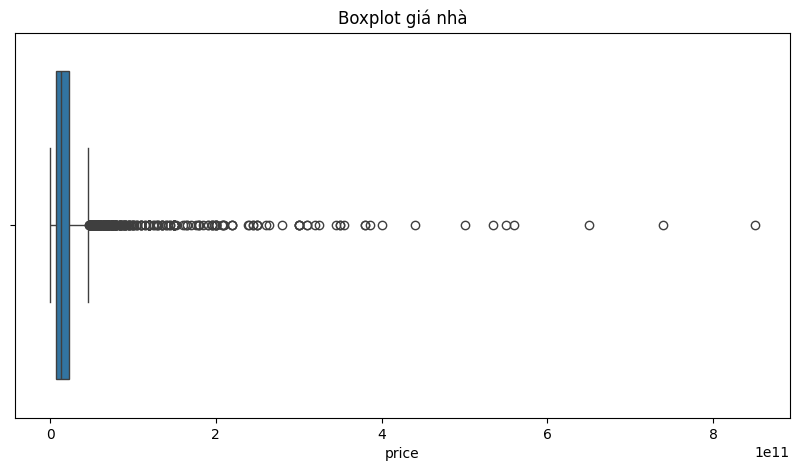

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_house['price'])
plt.title("Boxplot giá nhà")
plt.show()


#### Loại bỏ các giá trị outliers bằng cách chỉ lấy các giá trị thuộc vùng -17450000000.0 đến 46950000000.0

In [39]:
df_house_outlier=df_house[df_house['price']<=upper_price]

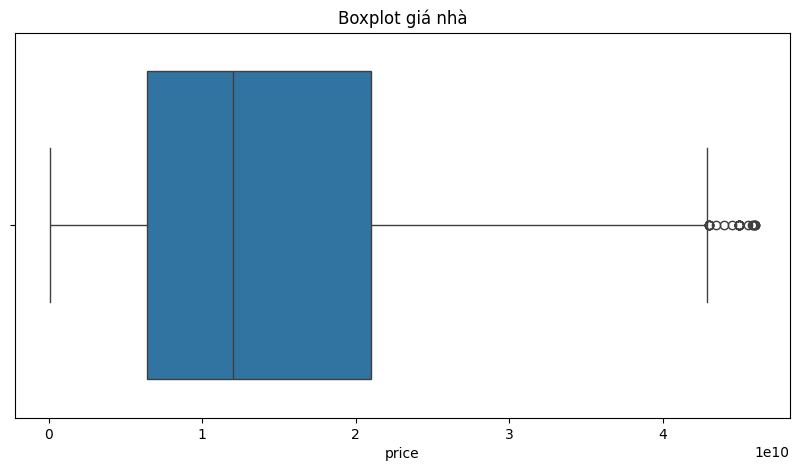

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_house_outlier['price'])
plt.title("Boxplot giá nhà")
plt.show()


### 4.2. Giá trị outlier cột square

#### Tương tự ta làm với cột Square

In [41]:
lower_square, upper_square= show_lower_upper_iqr(df_house_outlier,'square')
print(lower_square,upper_square)

-42.30000000000001 262.18


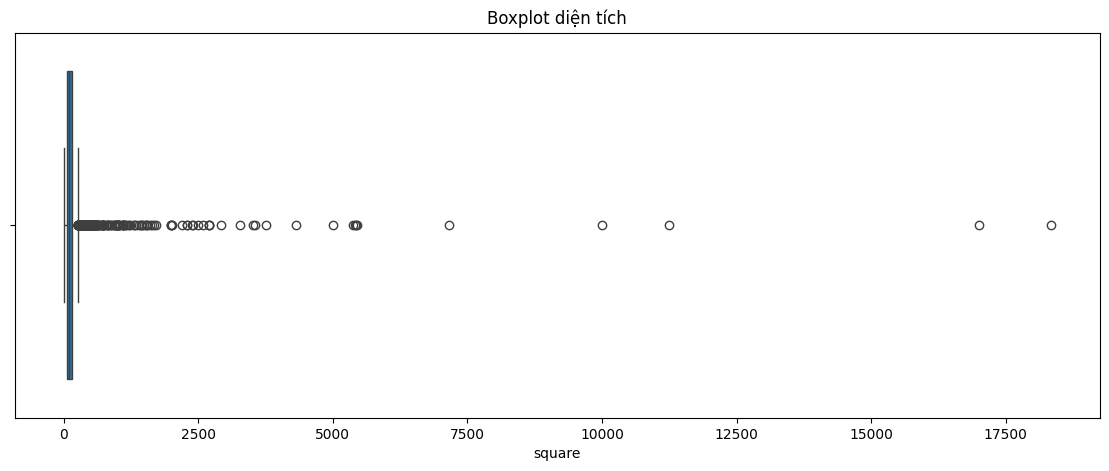

In [42]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier['square'])
plt.title("Boxplot diện tích")
plt.show()

In [43]:
df_house_outlier_1=df_house_outlier[df_house_outlier['square']<=upper_square]

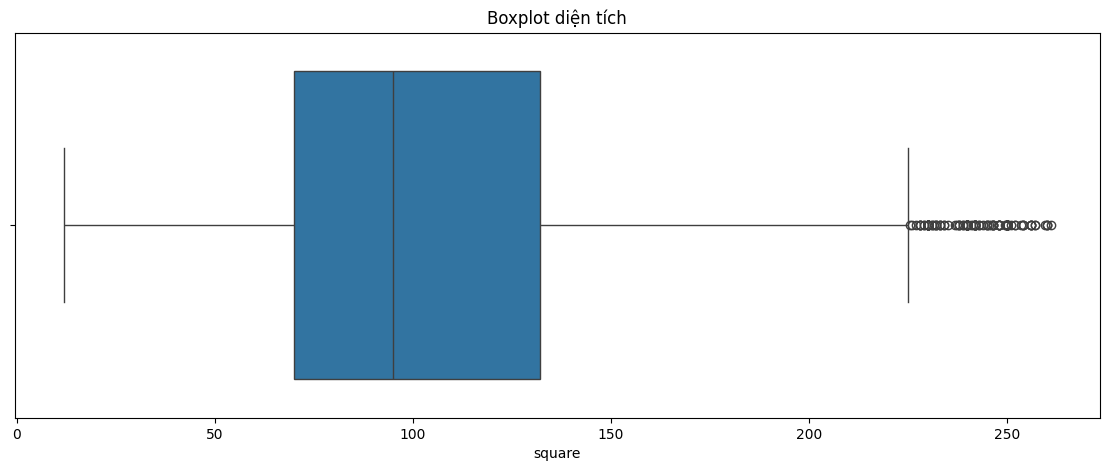

In [44]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_1['square'])
plt.title("Boxplot diện tích")
plt.show()

### 4.3. Giá trị outlier cột price_per_square

#### Tương tự với cột price_per_square

In [45]:
lower_price_per_square, upper_price_per_square= show_lower_upper_iqr(df_house_outlier_1,'price_per_square')
print(lower_price_per_square,upper_price_per_square)

-80.05500000000004 325.865


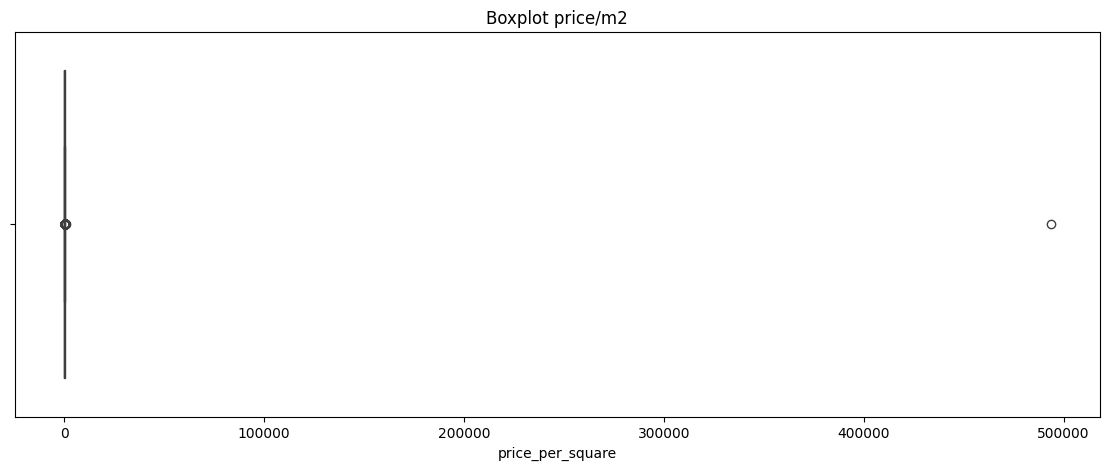

In [46]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_1['price_per_square'])
plt.title("Boxplot price/m2")
plt.show()

In [47]:
df_house_outlier_done=df_house_outlier_1[df_house_outlier_1['price_per_square']<=upper_price_per_square]

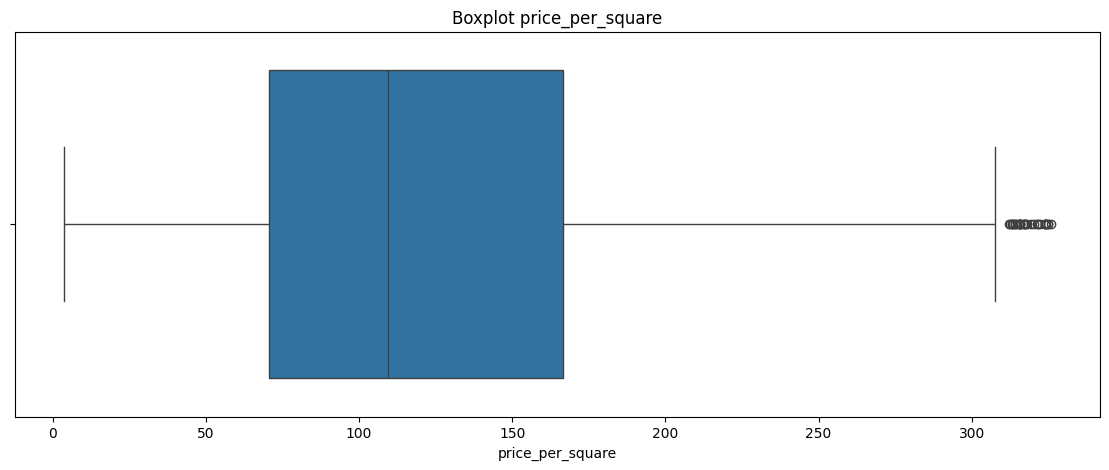

In [48]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_done['price_per_square'])
plt.title("Boxplot price_per_square")
plt.show()

In [52]:
df_house=df_house_outlier_done

### 4.3. Giá trị outlier cột wc

In [49]:
lower_price_per_square, upper_price_per_square= show_lower_upper_iqr(df_house_outlier_done,'wc')
print(lower_price_per_square,upper_price_per_square)

-1.0 7.0


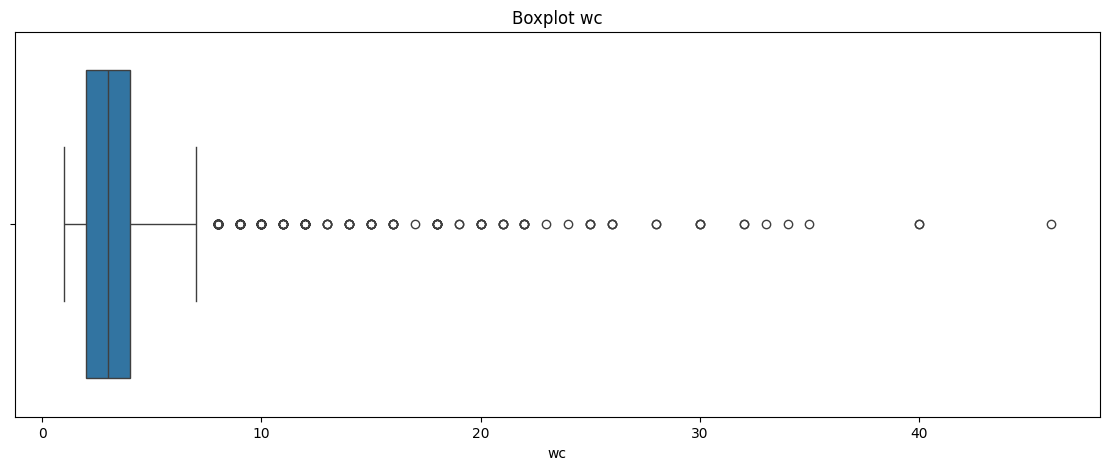

In [51]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_done['wc'])
plt.title("Boxplot wc")
plt.show()

In [53]:
df_house_outlier_done=df_house_outlier_done[df_house_outlier_done['wc']<=upper_price_per_square]

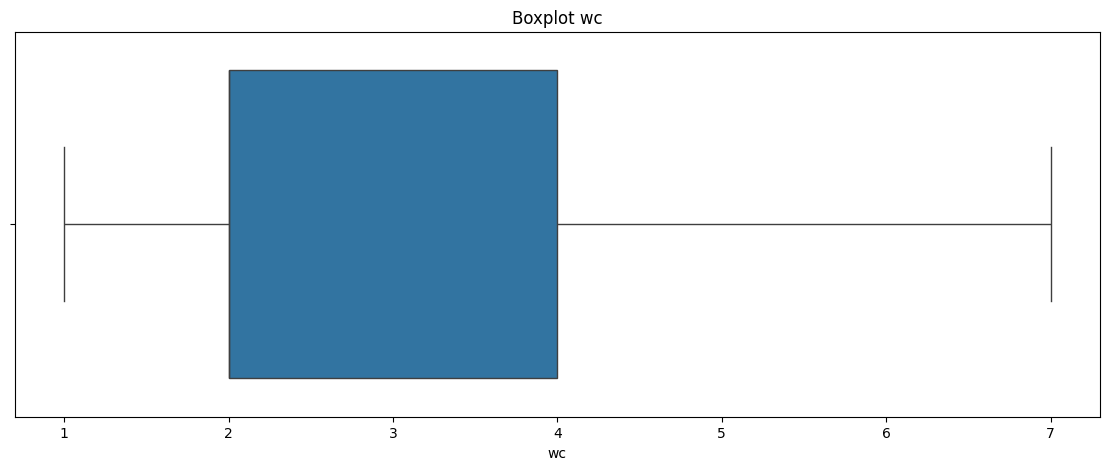

In [54]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_done['wc'])
plt.title("Boxplot wc")
plt.show()

### 4.4. Giá trị outlier cột bedroom

In [57]:
lower_price_per_square, upper_price_per_square= show_lower_upper_iqr(df_house_outlier_done,'bedroom')
print(lower_price_per_square,upper_price_per_square)

1.5 5.5


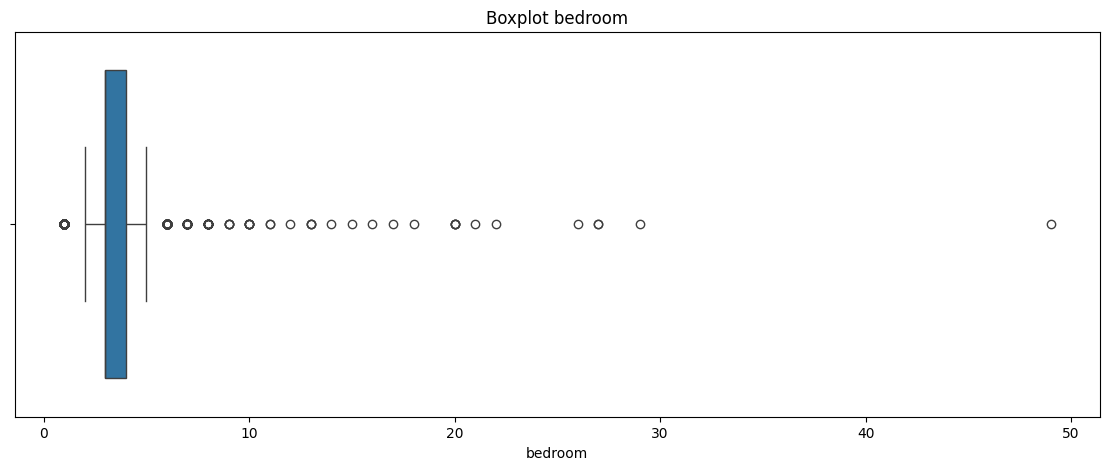

In [58]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_done['bedroom'])
plt.title("Boxplot bedroom")
plt.show()

In [59]:
df_house_outlier_done=df_house_outlier_done[df_house_outlier_done['bedroom']<=upper_price_per_square]

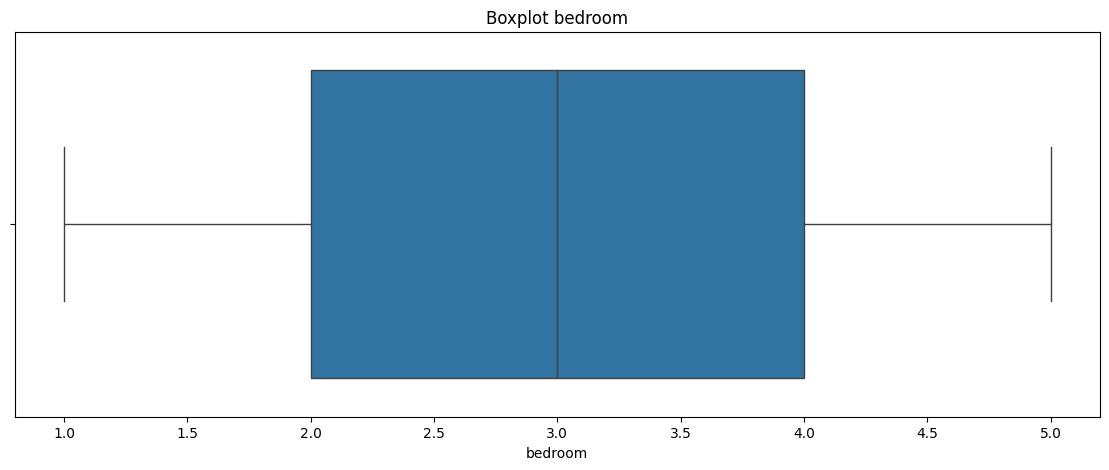

In [60]:
plt.figure(figsize=(14, 5))
sns.boxplot(x=df_house_outlier_done['bedroom'])
plt.title("Boxplot bedroom")
plt.show()

In [61]:
df_house_outlier_done.shape

(3832, 18)

In [62]:
df_house=df_house_outlier_done

## 5. Thiết lập lại chỉ mục cho đúng theo thứ tự để tránh xáo trộn dữ liệu

In [64]:
df_house=df_house.reset_index(drop=True)
df_house.shape

(3832, 18)

In [65]:
df_house.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Nội thất,Hướng nhà,Pháp lý,Mặt tiền,Số tầng,Đường vào,Loai_nha_clean,district
0,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,NaN,NaN,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
1,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Đầy đủ,Đông,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Quận 1
2,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Cơ bản,NaN,Hợp đồng mua bán,NaN,NaN,NaN,Căn hộ chung cư,Thủ Đức
3,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,NT cơ bản,NaN,Sổ đỏ/ Sổ hồng,NaN,NaN,NaN,Căn hộ chung cư,Bình Thạnh
4,CHÍNH CHỦ BÁN GẤP NHÀ MẶT TIỀN DT 100M2 ĐƯỜNG ...,1.650000e+10,100.0,165.00,3.0,2.0,"Bình Chánh, Hồ Chí Minh",10.737875,106.670557,Nhà mặt phố tại đường Chánh Hưng,Full nội thất cao cấp,NaN,Đầy đủ,NaN,NaN,NaN,Nhà mặt phố,Bình Chánh


#### Sau khi làm sạch dử liệu ta còn 4179 dòng và 18 cột

## 6. Loại bỏ các cột không cần thiết

In [66]:
df_house_Last_Done=df_house

In [67]:
#Vì các giá trị Nội thất, Hướng nhà, Mặt tiền, Số tầng, Đường vào chiếm giá trị Null khá lớn nên ta tiến thành loại bỏ các cột đó
df_house_Last_Done=df_house_Last_Done.drop(columns=["Nội thất","Hướng nhà","Mặt tiền","Số tầng","Đường vào","Pháp lý"])

## 7. Tạo thêm cột mới

Vì giá nhà thường hay biến động theo khoảng cách tới các quận/trung tâm quan trọng của TP.HCM nên ta tạo thêm các cột khoảng cách đến đó, ở đây ta xét các vị trí như Bưu Điện Tp.HCM(Quận 1), UBND(Quận 3), Trung tâm Bình Thạnh, Phú Mỹ Hưng(Quận 7), Sân bay Tân Sơn Nhất .

In [68]:
import numpy as np

# Hàm tính khoảng cách Haversine (km)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # bán kính Trái đất (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# Tọa độ trung tâm các quận/khu vực quan trọng
important_centers = {
    "quan_1": (10.7769, 106.7009),    # Bưu điện TP.HCM
    "quan_3": (10.7842, 106.6943),    # UBND Quận 3
    "binh_thanh": (10.8019, 106.7112),# Trung tâm Bình Thạnh
    "phu_nhuan": (10.7972, 106.6800), # Trung tâm Phú Nhuận
    "quan_7": (10.7370, 106.7218),    # Phú Mỹ Hưng
    "tan_binh_airport": (10.8185, 106.6580)  # Sân bay Tân Sơn Nhất
}

# Tạo feature khoảng cách đến từng trung tâm
for name, (lat, lon) in important_centers.items():
    df_house_Last_Done[f"dist_{name}"] = df_house_Last_Done.apply(
        lambda row: haversine(row["Lat"], row["Lon"], lat, lon), axis=1
    )

# Kiểm tra vài dòng
print(df_house_Last_Done[[col for col in df_house_Last_Done.columns if col.startswith("dist_")]].head())

   dist_quan_1  dist_quan_3  dist_binh_thanh  dist_phu_nhuan  dist_quan_7  \
0     0.855808     1.021520         2.143497        2.965443     5.600614   
1     0.857161     1.011252         2.142661        2.953979     5.609104   
2    14.480820    14.213538        11.539379       14.130382    17.561741   
3     2.952800     3.134288         1.324275        4.476085     6.423472   
4     5.460514     5.767225         8.390136        6.676805     5.598997   

   dist_tan_binh_airport  
0               6.284029  
1               6.272748  
2              14.542652  
3               7.360234  
4               9.069430  


In [69]:
df_house_Last_Done.head()

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Loai_nha_clean,district,dist_quan_1,dist_quan_3,dist_binh_thanh,dist_phu_nhuan,dist_quan_7,dist_tan_binh_airport
0,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Căn hộ chung cư,Quận 1,0.855808,1.021520,2.143497,2.965443,5.600614,6.284029
1,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Căn hộ chung cư,Quận 1,0.857161,1.011252,2.142661,2.953979,5.609104,6.272748
2,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Căn hộ chung cư,Thủ Đức,14.480820,14.213538,11.539379,14.130382,17.561741,14.542652
3,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,Căn hộ chung cư,Bình Thạnh,2.952800,3.134288,1.324275,4.476085,6.423472,7.360234
4,CHÍNH CHỦ BÁN GẤP NHÀ MẶT TIỀN DT 100M2 ĐƯỜNG ...,1.650000e+10,100.0,165.00,3.0,2.0,"Bình Chánh, Hồ Chí Minh",10.737875,106.670557,Nhà mặt phố tại đường Chánh Hưng,Nhà mặt phố,Bình Chánh,5.460514,5.767225,8.390136,6.676805,5.598997,9.069430


## 8. Lưu dữ liệu đã làm sạch vào file excel

In [70]:
df_house_Last_Done.to_excel('Data/Zz_Predit_house_cleaned_last.xlsx', index=False)

## 9. Trực quan hóa dữ liệu sau khi đã được làm sạch

In [71]:
df_house_done_clean=pd.read_excel('Data/Zz_Predit_house_cleaned_last.xlsx')

### 9.1. Biểu đồ phân bố giá nhà (Price)

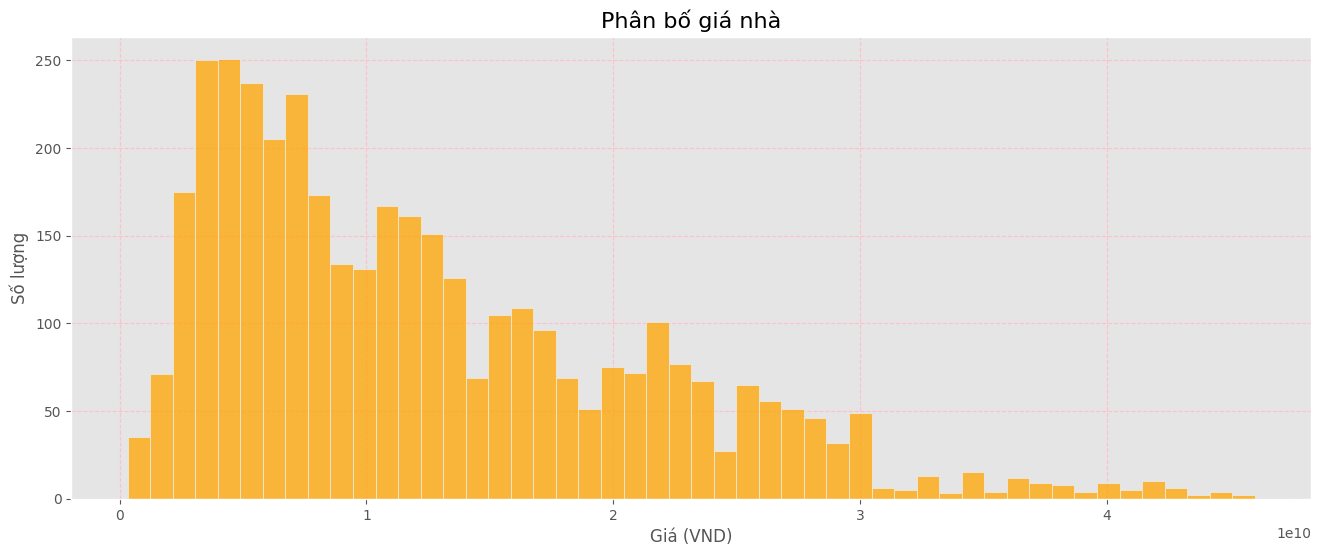

In [ ]:
plt.figure(figsize=(16,6))
sns.histplot(
    data=df_house_done_clean,
    x=df_house_done_clean['price'], bins=50, color='orange')
plt.title("Phân bố giá nhà", fontsize=16)
plt.xlabel("Giá (VND)",fontsize=12)
plt.ylabel("Số lượng",fontsize=12)
plt.grid(True, ls='--', color='pink')
plt.show()

### 9.2. Biểu đồ phân bố giá nhà theo trung bình quận (district)


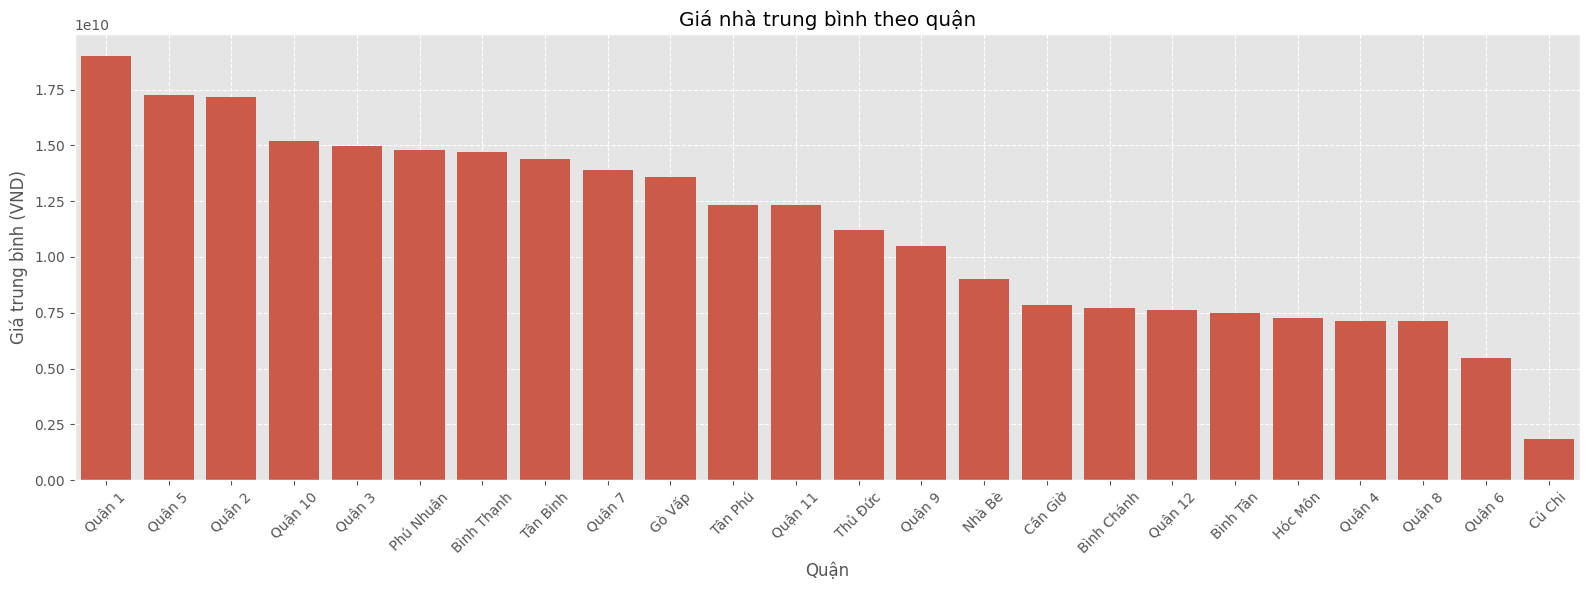

In [73]:
plt.figure(figsize=(16,6))
avg_price_by_district = df_house_done_clean.groupby('district')['price'].mean().sort_values(ascending=False)
sns.barplot(x=avg_price_by_district.index, y=avg_price_by_district.values)
plt.title("Giá nhà trung bình theo quận")
plt.ylabel("Giá trung bình (VND)")
plt.xlabel("Quận")
plt.xticks(rotation=45)
plt.grid(True, ls='--')
plt.tight_layout()
plt.show()

### 9.3. Mối quan hệ giữa diện tích (square) và giá



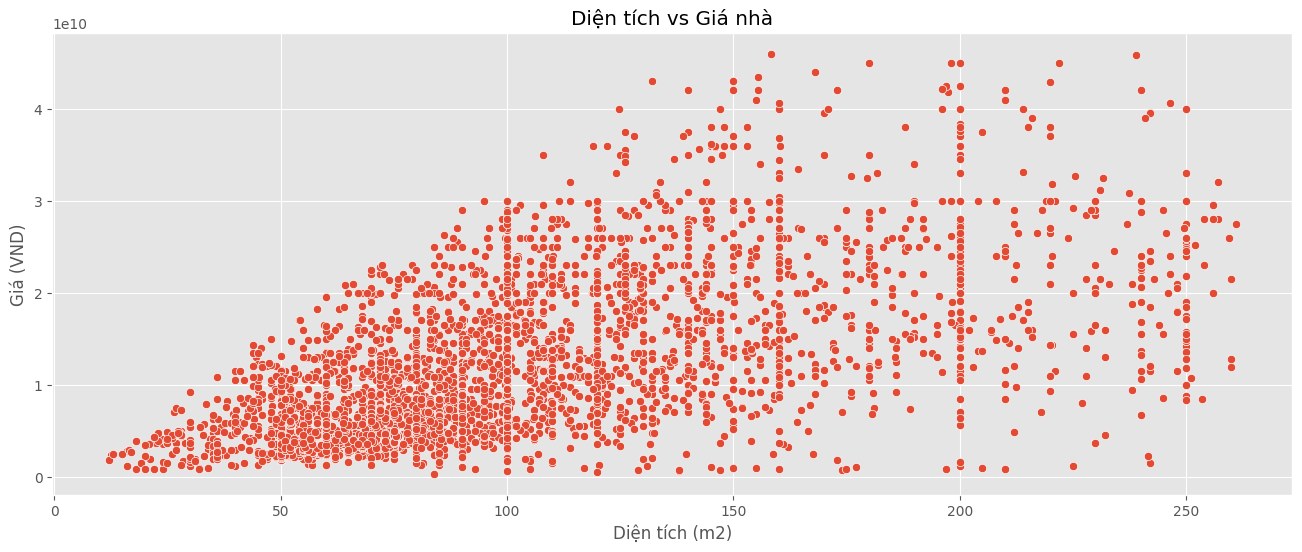

In [74]:
plt.figure(figsize=(16,6))
sns.scatterplot(data=df_house_done_clean, x='square', y='price')
plt.title("Diện tích vs Giá nhà")
plt.xlabel("Diện tích (m2)")
plt.ylabel("Giá (VND)")
plt.grid(True)
plt.show()


### 9.4. Biểu đồ hộp (boxplot) giá theo số phòng ngủ


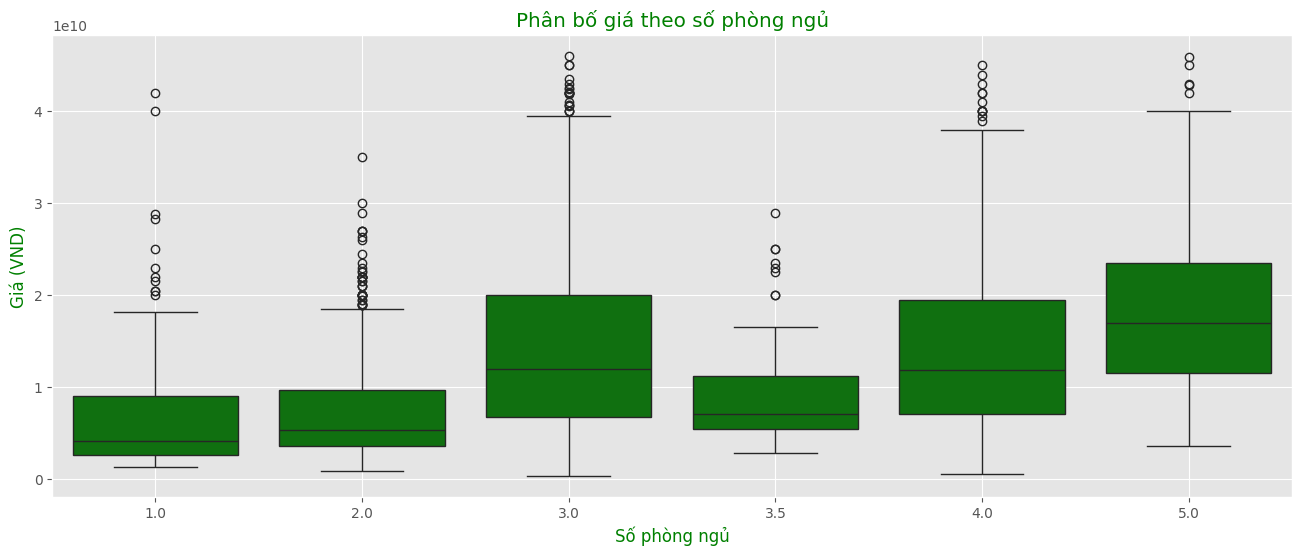

In [75]:
plt.figure(figsize=(16,6))
sns.boxplot(x='bedroom', y='price', data=df_house_done_clean, color='green')
plt.title("Phân bố giá theo số phòng ngủ", color='green')
plt.xlabel("Số phòng ngủ", color='green')
plt.ylabel("Giá (VND)", color='green')
plt.grid(True)
plt.show()


# III. Sử dụng mô hình Machine Learning Random Forest để dự đoán giá nhà

## 1. Dùng LabelEncoder cho cột district và loại nhà


In [29]:
df_house=pd.read_excel("Data/Zz_Predit_house_cleaned_last.xlsx")

In [30]:
df_house=df_house.drop_duplicates()

In [31]:
df_house.shape

(3826, 18)

In [32]:
from sklearn.preprocessing import LabelEncoder

le_loai_nha = LabelEncoder()
# le_phap_ly = LabelEncoder()
le_district = LabelEncoder()

df_house["Loai_nha_clean_encoded"] = le_loai_nha.fit_transform(df_house["Loai_nha_clean"])
# df_house["phap_ly_clean_encoded"] = le_phap_ly.fit_transform(df_house["phap_ly_clean"])
df_house["district_encoded"] = le_district.fit_transform(df_house["district"])


In [33]:
df_house.head(5)

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Loai_nha_clean,district,dist_quan_1,dist_quan_3,dist_binh_thanh,dist_phu_nhuan,dist_quan_7,dist_tan_binh_airport,Loai_nha_clean_encoded,district_encoded
0,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Căn hộ chung cư,Quận 1,0.855808,1.021520,2.143497,2.965443,5.600614,6.284029,2,9
1,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Căn hộ chung cư,Quận 1,0.857161,1.011252,2.142661,2.953979,5.609104,6.272748,2,9
2,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Căn hộ chung cư,Thủ Đức,14.480820,14.213538,11.539379,14.130382,17.561741,14.542652,2,21
3,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,Căn hộ chung cư,Bình Thạnh,2.952800,3.134288,1.324275,4.476085,6.423472,7.360234,2,1
4,CHÍNH CHỦ BÁN GẤP NHÀ MẶT TIỀN DT 100M2 ĐƯỜNG ...,1.650000e+10,100.0,165.00,3.0,2.0,"Bình Chánh, Hồ Chí Minh",10.737875,106.670557,Nhà mặt phố tại đường Chánh Hưng,Nhà mặt phố,Bình Chánh,5.460514,5.767225,8.390136,6.676805,5.598997,9.069430,5,0


In [21]:
df_house.shape

(3826, 20)

## 2. Loại bỏ các cột không cần thiết

In [34]:
df_LableEncoder=df_house.drop(columns=['title','location','Lat','Lon','Loại nhà','district','Loai_nha_clean','price_per_square'])
df_LableEncoder.head()

,price,square,bedroom,wc,dist_quan_1,dist_quan_3,dist_binh_thanh,dist_phu_nhuan,dist_quan_7,dist_tan_binh_airport,Loai_nha_clean_encoded,district_encoded
0,2.000000e+10,100.0,3.0,2.0,0.855808,1.021520,2.143497,2.965443,5.600614,6.284029,2,9
1,1.750000e+10,120.0,3.0,3.0,0.857161,1.011252,2.142661,2.953979,5.609104,6.272748,2,9
2,3.150000e+09,70.0,2.0,2.0,14.480820,14.213538,11.539379,14.130382,17.561741,14.542652,2,21
3,6.800000e+09,85.0,2.0,2.0,2.952800,3.134288,1.324275,4.476085,6.423472,7.360234,2,1
4,1.650000e+10,100.0,3.0,2.0,5.460514,5.767225,8.390136,6.676805,5.598997,9.069430,5,0


In [35]:
df_LableEncoder.isnull().sum()

price                     0
square                    0
bedroom                   0
wc                        0
dist_quan_1               0
dist_quan_3               0
dist_binh_thanh           0
dist_phu_nhuan            0
dist_quan_7               0
dist_tan_binh_airport     0
Loai_nha_clean_encoded    0
district_encoded          0
dtype: int64

## 3. Huấn luyện mô hình random forest

In [36]:
y=df_LableEncoder['price']
X=df_LableEncoder.drop(columns=['price'])

In [86]:
X

,square,bedroom,wc,dist_quan_1,dist_quan_3,dist_binh_thanh,dist_phu_nhuan,dist_quan_7,dist_tan_binh_airport,Loai_nha_clean_encoded,district_encoded
0,100.0,3.0,2.0,0.855808,1.021520,2.143497,2.965443,5.600614,6.284029,2,9
1,120.0,3.0,3.0,0.857161,1.011252,2.142661,2.953979,5.609104,6.272748,2,9
2,70.0,2.0,2.0,14.480820,14.213538,11.539379,14.130382,17.561741,14.542652,2,21
3,85.0,2.0,2.0,2.952800,3.134288,1.324275,4.476085,6.423472,7.360234,2,1
4,100.0,3.0,2.0,5.460514,5.767225,8.390136,6.676805,5.598997,9.069430,5,0
...,...,...,...,...,...,...,...,...,...,...,...
3827,160.0,3.0,2.0,8.590222,9.187993,7.387065,10.726620,8.658786,13.443131,8,13
3828,176.0,3.0,2.0,6.093206,6.954078,6.096127,8.873996,5.203842,12.030807,8,13
3829,148.0,3.0,3.0,5.089229,6.046602,7.782423,7.943746,1.451038,11.152877,8,18
3830,100.0,3.0,2.0,5.934445,6.685989,5.478588,8.480668,5.863152,11.521876,8,13


In [89]:
y

0       2.000000e+10
1       1.750000e+10
2       3.150000e+09
3       6.800000e+09
4       1.650000e+10
            ...     
3827    1.760000e+10
3828    3.273000e+10
3829    3.800000e+10
3830    2.150000e+10
3831    3.680000e+10
Name: price, Length: 3826, dtype: float64

In [37]:
# ================== CHUẨN BỊ DỮ LIỆU ==================
feature_cols = [
    "square","bedroom","wc",
    "dist_quan_1","dist_quan_3","dist_binh_thanh",
    "dist_phu_nhuan","dist_quan_7","dist_tan_binh_airport",
    "Loai_nha_clean_encoded","district_encoded"
]
X = df_LableEncoder[feature_cols]
y = df_LableEncoder["price"].values

# Chia 2 phân khúc
mask_high = y >= 20e9
X_low, y_low   = X[~mask_high], y[~mask_high]          # < 20 tỷ
X_high, y_high = X[mask_high], np.log1p(y[mask_high])  # ≥ 20 tỷ (log)

# ================== MODEL ==================
model_low = RandomForestRegressor(
    n_estimators=300, min_samples_leaf=3, random_state=41, n_jobs=-1
)
model_low.fit(X_low, y_low)

model_high = RandomForestRegressor(
    n_estimators=300, min_samples_leaf=3, random_state=41, n_jobs=-1
)
model_high.fit(X_high, y_high)

# ================== HÀM DỰ ĐOÁN ==================
def predict_price_segmented(X_new):
    """
    Quy tắc:
    - Nếu dự đoán < 20 tỷ → dùng model_low (train trực tiếp price)
    - Nếu dự đoán ≥ 20 tỷ → dùng model_high (train log(price))
    """
    # B1: thử dự đoán nhanh bằng model_low để phân loại trước
    rough_pred = model_low.predict(X_new)[0]
    
    if rough_pred < 20e9:
        return model_low.predict(X_new)[0]
    else:
        return np.expm1(model_high.predict(X_new)[0])
def rmse_safe(y_true, y_pred):
    """
    Trả về RMSE theo cách an toàn: nếu mean_squared_error hỗ trợ 'squared',
    dùng nó; nếu không, tính sqrt của MSE thủ công.
    """
    try:
        # ưu tiên dùng tham số squared nếu có (một số phiên bản sklearn có)
        return mean_squared_error(y_true, y_pred, squared=False)
    except TypeError:
        # fallback: dùng MSE rồi sqrt
        return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_model(model, X, y, is_y_log=False):
    """
    Đánh giá model bằng MAE, RMSE, R2.
    - model: object đã fit
    - X: features (DataFrame/array)
    - y: ground-truth targets; nếu is_y_log=True thì y là log1p(y) (như y_high trong pipeline của bạn)
    - trả về dict với MAE, RMSE, R2 (units: nguyên VNĐ)
    """
    y_pred_raw = model.predict(X)
    if is_y_log:
        # model được train trên log1p -> phải expm1 để về tiền tệ gốc
        y_pred = np.expm1(y_pred_raw)
        y_true = np.expm1(y)
    else:
        y_pred = y_pred_raw
        y_true = y

    mae = mean_absolute_error(y_true, y_pred)
    rmse = rmse_safe(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

## 4. Đánh giá mô hình

In [38]:
# Đánh giá phân khúc <20 tỷ
metrics_low = evaluate_model(model_low, X_low, y_low, is_y_log=False)
print("📊 Model LOW (<20 tỷ):", metrics_low)

# Đánh giá phân khúc ≥20 tỷ
metrics_high = evaluate_model(model_high, X_high, y_high, is_y_log=True)
print("📊 Model HIGH (≥20 tỷ):", metrics_high)

📊 Model LOW (<20 tỷ): {'MAE': 875396386.0092455, 'RMSE': 1276298735.5449953, 'R2': 0.9291066297684121}
📊 Model HIGH (≥20 tỷ): {'MAE': 1867947729.058747, 'RMSE': 2755939860.3019853, 'R2': 0.7536371737562944}


## 5. Tiến hành dự đoán giá nhà

In [92]:
import re
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# ==============================
# 1. Hàm chuyển đổi DMS -> Decimal Degrees
# ==============================
def dms_to_decimal(dms_str):
    regex = r"(\d+)°(\d+)'([\d\.]+)\"?([NSEW])"
    match = re.match(regex, dms_str.strip())
    if not match:
        raise ValueError("Sai định dạng DMS. Ví dụ: 10°50'55.5\"N")
    
    degrees, minutes, seconds, direction = match.groups()
    decimal = float(degrees) + float(minutes)/60 + float(seconds)/3600
    
    if direction in ['S', 'W']:
        decimal = -decimal
    
    return decimal

# ==============================
# 2. Hàm tính khoảng cách Haversine (km)
# ==============================
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # bán kính Trái đất (km)
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

# ==============================
# 3. Tọa độ trung tâm quan trọng
# ==============================
important_centers = {
    "dist_quan_1": (10.7769, 106.7009),
    "dist_quan_3": (10.7842, 106.6943),
    "dist_binh_thanh": (10.8019, 106.7112),
    "dist_phu_nhuan": (10.7972, 106.6800),
    "dist_quan_7": (10.7370, 106.7218),
    "dist_tan_binh_airport": (10.8185, 106.6580)
}

# ==============================
# 4. Hàm tính khoảng cách từ tọa độ nhập vào
# ==============================
def compute_distances(lat_dms, lon_dms):
    lat = dms_to_decimal(lat_dms)
    lon = dms_to_decimal(lon_dms)
    
    dist_features = {}
    for name, (clat, clon) in important_centers.items():
        dist_features[name] = haversine(lat, lon, clat, clon)
    
    return dist_features

# ==============================
# 5. Danh sách feature y hệt lúc train
# ==============================
feature_cols = [
    'square',
    'bedroom',
    'wc',
    'dist_quan_1',
    'dist_quan_3',
    'dist_binh_thanh',
    'dist_phu_nhuan',
    'dist_quan_7',
    'dist_tan_binh_airport',
    'Loai_nha_clean_encoded',
    # 'phap_ly_clean_encoded',
    'district_encoded'
]

# ==============================
# 7. Hàm dự đoán giá (segmented)
# ==============================
def predict_price(lat_dms, lon_dms, square, bedroom, wc, loai_nha, district):
    # Tính khoảng cách
    distances = compute_distances(lat_dms, lon_dms)
    
    # Tạo dict dữ liệu
    new_data = {
        'square': square,
        'bedroom': bedroom,
        'wc': wc,
        'Loai_nha_clean_encoded': le_loai_nha.transform([loai_nha])[0],
        # 'phap_ly_clean_encoded': le_phap_ly.transform([phap_ly])[0],
        'district_encoded': le_district.transform([district])[0]
    }
    new_data.update(distances)

    # Chuyển thành DataFrame theo đúng thứ tự feature_cols
    X_new = pd.DataFrame([[new_data[col] for col in feature_cols]], columns=feature_cols)

    # Dự đoán sơ bộ bằng model_low
    rough_pred = model_low.predict(X_new)[0]
    
    if rough_pred < 20e9:
        final_price = rough_pred
    else:
        final_price = np.expm1(model_high.predict(X_new)[0])

    return final_price, X_new

# ==============================
# 8. Ví dụ chạy thử
# ==============================
lat_dms = '10°46\'20.1"N'
lon_dms = '106°42\'48.3"E'

pred_price, X_used = predict_price(
    lat_dms, lon_dms,
    square=83,
    bedroom=2,
    wc=2,
    loai_nha='Căn hộ chung cư',
    # phap_ly='Sổ hồng',
    district='Quận 2'
)

print("📍 Features dùng để dự đoán:\n", X_used)
print(f"\n✅ Giá nhà dự đoán: {pred_price:,.0f} VNĐ")


📍 Features dùng để dự đoán:
    square  bedroom  wc  dist_quan_1  dist_quan_3  dist_binh_thanh  \
0      83        2   2     1.461755     2.475103         3.305809   

   dist_phu_nhuan  dist_quan_7  dist_tan_binh_airport  Loai_nha_clean_encoded  \
0        4.584788     4.025188               7.942721                       2   

   district_encoded  
0                13  

✅ Giá nhà dự đoán: 16,700,542,811 VNĐ


## 6. Minh họa đặc trưng quan trọng, độ chính xác của mô hình, sai số dự đoán 

### 6.1. Đặc trưng quan trọng

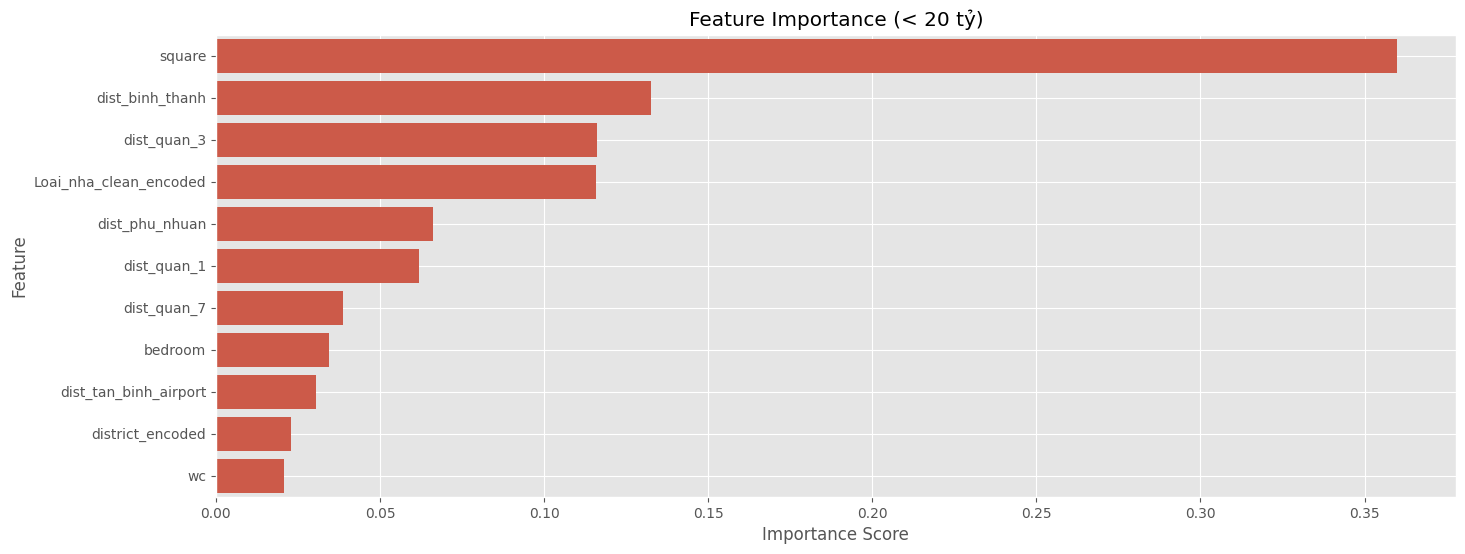

In [93]:

importances = model_low.feature_importances_
features = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(len(importances))]
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(16,6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance (< 20 tỷ)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


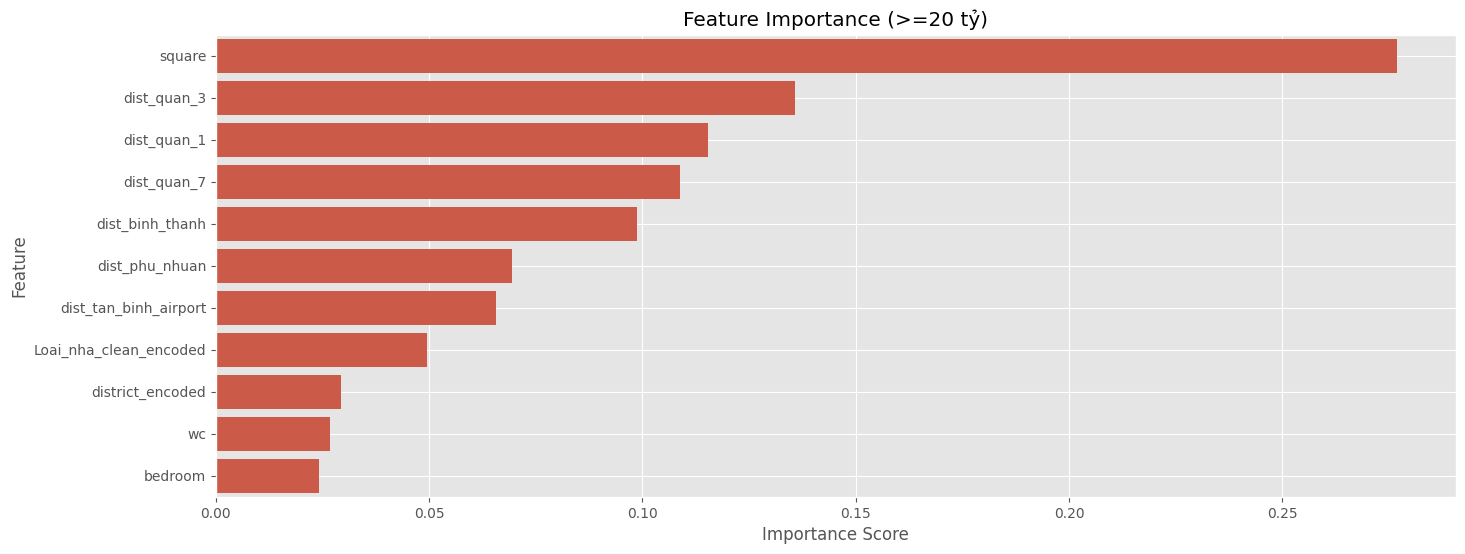

In [94]:
importances = model_high.feature_importances_
features = X.columns if hasattr(X, 'columns') else [f'Feature {i}' for i in range(len(importances))]
feature_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_df = feature_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(16,6))
sns.barplot(x='Importance', y='Feature', data=feature_df)
plt.title("Feature Importance (>=20 tỷ)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.show()

### 6.2. Độ chính xác của mô hình

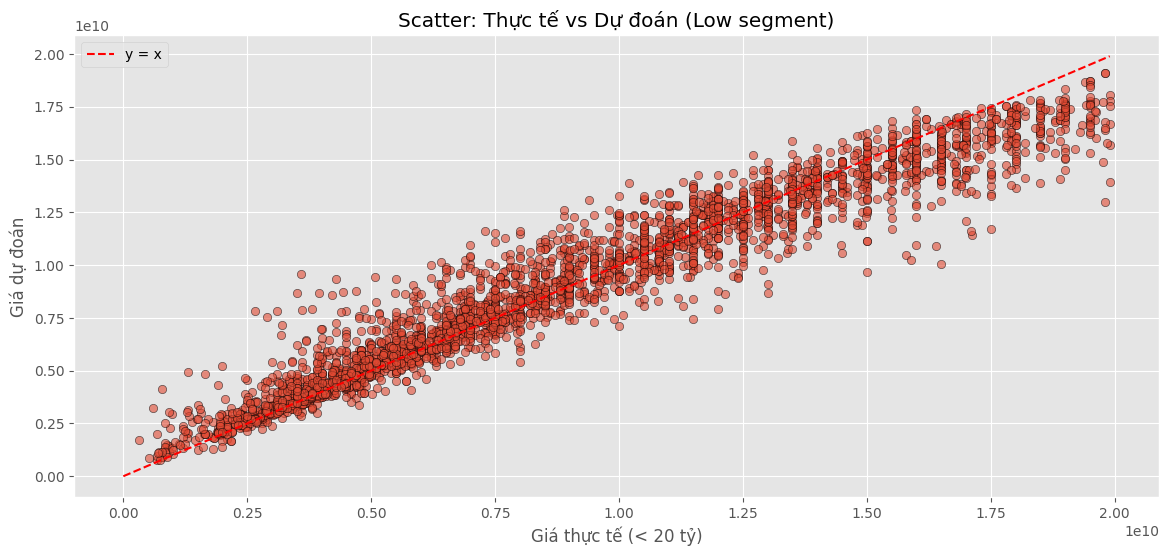

In [95]:

# === LOW segment ===
y_pred_low = model_low.predict(X_low)
plt.figure(figsize=(14,6))
plt.scatter(y_low, y_pred_low, alpha=0.6, edgecolor='k')
plt.plot([0, max(y_low)], [0, max(y_low)], 'r--', label="y = x")  # đường tham chiếu
plt.xlabel("Giá thực tế (< 20 tỷ)")
plt.ylabel("Giá dự đoán")
plt.title("Scatter: Thực tế vs Dự đoán (Low segment)")
plt.legend()
plt.show()

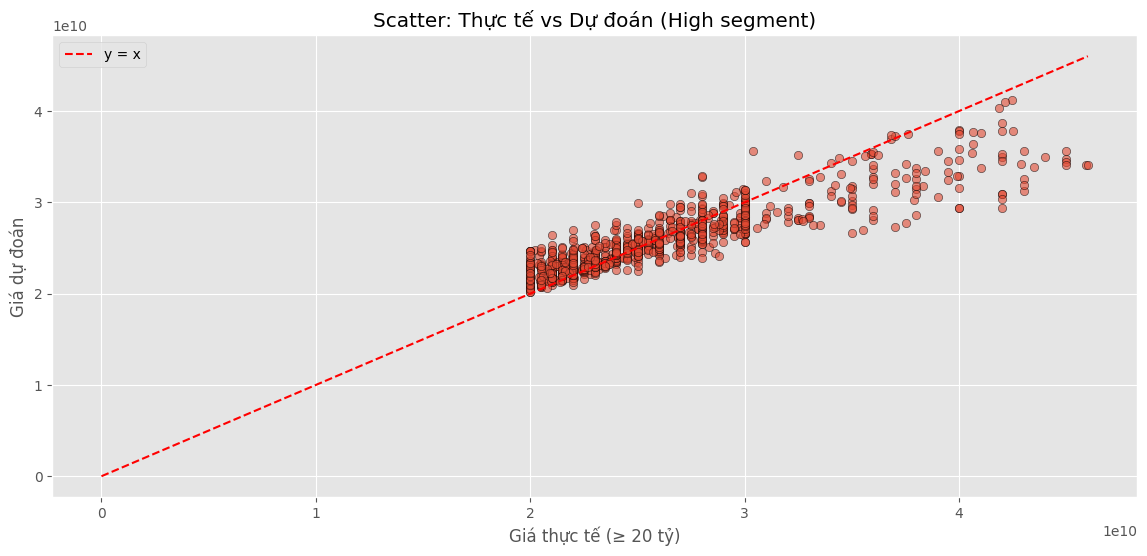

In [96]:
# === HIGH segment ===
y_pred_high = np.expm1(model_high.predict(X_high))
y_true_high = np.expm1(y_high)   # nhớ expm1 để đưa về đơn vị VNĐ gốc
plt.figure(figsize=(14,6))
plt.scatter(y_true_high, y_pred_high, alpha=0.6, edgecolor='k')
plt.plot([0, max(y_true_high)], [0, max(y_true_high)], 'r--', label="y = x")
plt.xlabel("Giá thực tế (≥ 20 tỷ)")
plt.ylabel("Giá dự đoán")
plt.title("Scatter: Thực tế vs Dự đoán (High segment)")
plt.legend()
plt.show()

### 6.3. Sai số dự đoán

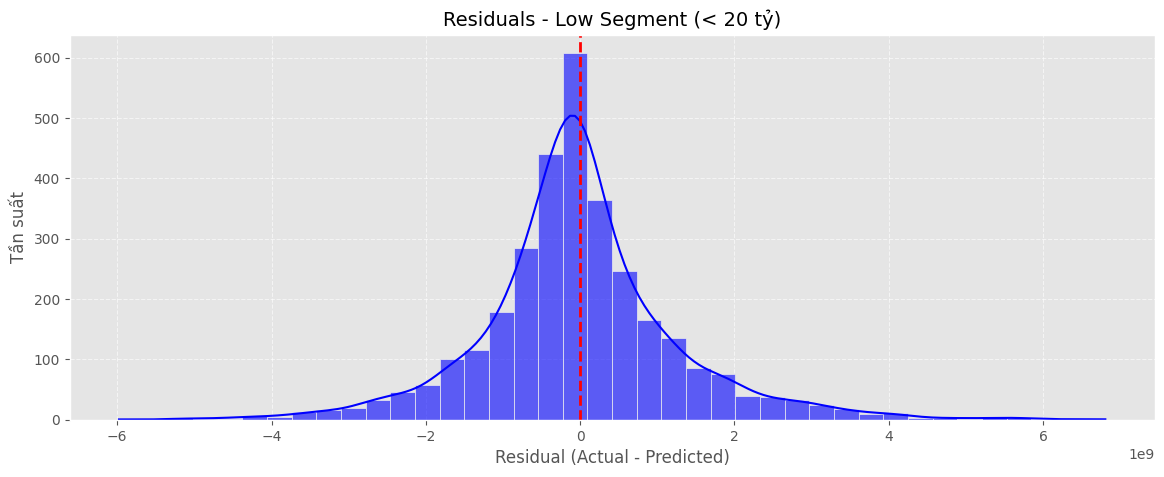

In [97]:
# ================== LOW SEGMENT (< 20 tỷ) ==================
y_pred_low = model_low.predict(X_low)
residuals_low = y_low - y_pred_low

plt.figure(figsize=(14,5))
sns.histplot(residuals_low, bins=40, kde=True, color="blue", alpha=0.6)
plt.axvline(0, color="red", linestyle="--", linewidth=2)
plt.title("Residuals - Low Segment (< 20 tỷ)", fontsize=14)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Tần suất")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

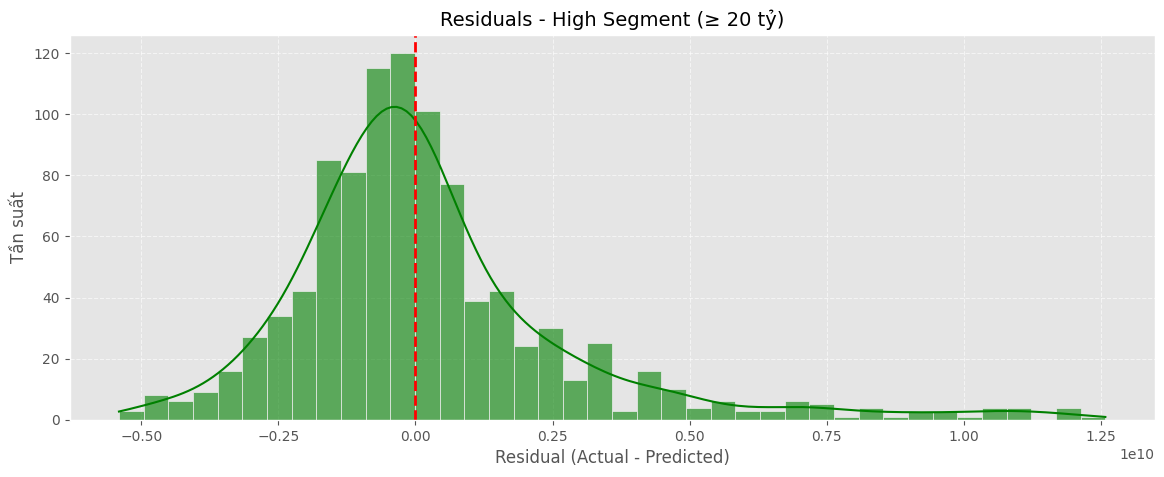

In [98]:
# ================== HIGH SEGMENT (≥ 20 tỷ, log-scale) ==================
y_pred_high = np.expm1(model_high.predict(X_high))   # về thang VNĐ gốc
y_true_high = np.expm1(y_high)
residuals_high = y_true_high - y_pred_high

plt.figure(figsize=(14,5))
sns.histplot(residuals_high, bins=40, kde=True, color="green", alpha=0.6)
plt.axvline(0, color="red", linestyle="--", linewidth=2)
plt.title("Residuals - High Segment (≥ 20 tỷ)", fontsize=14)
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Tần suất")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## 8. Lưu Meachine Learning và le (LabelEncoder) 

In [14]:
# model = joblib.load("models/house_price_model.pkl")
# le = joblib.load("models/district_label_encoder.pkl")
joblib.dump(model, "models/house_price_model.pkl")
joblib.dump(le, "models/district_label_encoder.pkl")

['models/district_label_encoder.pkl']

# <hr>

# IV. Mô hình Machine Learning Linear Regresstion

## 1. Load dữ liệu đã clean

In [39]:
df_houseLn=pd.read_excel("Data/Zz_Predit_house_cleaned_last.xlsx")

In [40]:
df_houseLn.shape

(3832, 18)

In [41]:
df_houseLn.head()


,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,Loai_nha_clean,district,dist_quan_1,dist_quan_3,dist_binh_thanh,dist_phu_nhuan,dist_quan_7,dist_tan_binh_airport
0,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Căn hộ chung cư,Quận 1,0.855808,1.021520,2.143497,2.965443,5.600614,6.284029
1,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,Căn hộ chung cư,Quận 1,0.857161,1.011252,2.142661,2.953979,5.609104,6.272748
2,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,Căn hộ chung cư,Thủ Đức,14.480820,14.213538,11.539379,14.130382,17.561741,14.542652
3,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,Căn hộ chung cư,Bình Thạnh,2.952800,3.134288,1.324275,4.476085,6.423472,7.360234
4,CHÍNH CHỦ BÁN GẤP NHÀ MẶT TIỀN DT 100M2 ĐƯỜNG ...,1.650000e+10,100.0,165.00,3.0,2.0,"Bình Chánh, Hồ Chí Minh",10.737875,106.670557,Nhà mặt phố tại đường Chánh Hưng,Nhà mặt phố,Bình Chánh,5.460514,5.767225,8.390136,6.676805,5.598997,9.069430


## 2. One-Hot Encoding cho cột district và loại nhà

In [42]:
# One-Hot Encoding cho cột district
district=pd.get_dummies(df_houseLn['district']).astype(int)
district.head()


,Bình Chánh,Bình Thạnh,Bình Tân,Cần Giờ,Củ Chi,Gò Vấp,Hóc Môn,Nhà Bè,Phú Nhuận,Quận 1,...,Quận 3,Quận 4,Quận 5,Quận 6,Quận 7,Quận 8,Quận 9,Thủ Đức,Tân Bình,Tân Phú
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# One-Hot Encoding cho cột loại nhà
loainha=pd.get_dummies(df_houseLn['Loai_nha_clean']).astype(int)
loainha.head()

,Bán đất,"Chung cư mini, căn hộ dịch vụ",Căn hộ chung cư,"Kho, nhà xưởng","Nhà biệt thự, liền kề",Nhà mặt phố,Nhà riêng,"Shophouse, nhà phố thương mại",Đất nền dự án
0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0


In [44]:
# Nối vào df_house
df_house_linear=pd.concat([df_houseLn,district,loainha], axis=1)

In [45]:
df_house_linear.head(10)

,title,price,square,price_per_square,bedroom,wc,location,Lat,Lon,Loại nhà,...,Tân Phú,Bán đất,"Chung cư mini, căn hộ dịch vụ",Căn hộ chung cư,"Kho, nhà xưởng","Nhà biệt thự, liền kề",Nhà mặt phố,Nhà riêng,"Shophouse, nhà phố thương mại",Đất nền dự án
0,GIỎ HÀNG CHUYỂN NHƯỢNG CĂN HỘ VINHOMES BA SON ...,2.000000e+10,100.0,200.00,3.0,2.0,"Quận 1, Hồ Chí Minh",10.784106,106.703651,Căn hộ chung cư tại Vinhomes Golden River Ba Son,...,0,0,0,1,0,0,0,0,0,0
1,CẬP NHẬT GIỎ HÀNG GIÁ TỐT 1PN-8TỶ 2PN-11TỶ5 3P...,1.750000e+10,120.0,145.83,3.0,3.0,"Quận 1, Hồ Chí Minh",10.784153,106.703558,Căn hộ chung cư tại Vinhomes Golden River Ba Son,...,0,0,0,1,0,0,0,0,0,0
2,"CĂN HỘ HAPPY ONE SORA THỦ ĐỨC, GIÁ CHỈ 3.1 TỶ ...",3.150000e+09,70.0,45.00,2.0,2.0,"Thủ Đức, Hồ Chí Minh",10.887277,106.771267,Căn hộ chung cư tại Happy One Sora,...,0,0,0,1,0,0,0,0,0,0
3,BÁN CĂN HỘ VINHOMES CENTRAL PARK GIÁ TỐT NHẤT ...,6.800000e+09,85.0,80.00,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794761,106.720904,Căn hộ chung cư tại Vinhomes Central Park,...,0,0,0,1,0,0,0,0,0,0
4,CHÍNH CHỦ BÁN GẤP NHÀ MẶT TIỀN DT 100M2 ĐƯỜNG ...,1.650000e+10,100.0,165.00,3.0,2.0,"Bình Chánh, Hồ Chí Minh",10.737875,106.670557,Nhà mặt phố tại đường Chánh Hưng,...,0,0,0,0,0,0,1,0,0,0
5,"BÁN CĂN HỘ 2PN/50M2. GIÁ 1,38 TỶ/SHR NGAY CHỢ ...",1.380000e+09,56.0,24.64,2.0,1.0,"Bình Chánh, Hồ Chí Minh",10.663202,106.566991,Căn hộ chung cư tại đường Quốc lộ 1A,...,0,0,0,1,0,0,0,0,0,0
6,"CĂN HỘ THE BEVERLY(OS2) VIEW PHÁO HOA GIÁ 2,98...",2.990000e+09,55.0,54.36,1.0,1.0,"Quận 9, Hồ Chí Minh",10.841504,106.840324,Căn hộ chung cư tại Vinhomes Grand Park,...,0,0,0,1,0,0,0,0,0,0
7,CẬP NHẬT GIỎ HÀNG GIÁ TỐT (1PN-5TỶ) (2PN-7TỶ2)...,1.030000e+10,120.0,85.83,3.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794844,106.721194,Căn hộ chung cư tại Vinhomes Central Park,...,0,0,0,1,0,0,0,0,0,0
8,CẬP NHẬT GIỎ HÀNG GIÁ TỐT [1PN - 5TỶ2] [2PN - ...,6.900000e+09,83.0,83.13,2.0,2.0,"Bình Thạnh, Hồ Chí Minh",10.794863,106.720376,Căn hộ chung cư tại Vinhomes Central Park,...,0,0,0,1,0,0,0,0,0,0
9,"CẦN BÁN CĂN 2PN2WC 73M2 GIÁ 3,15 TỶ VIEW THOÁN...",3.150000e+09,73.0,43.15,2.0,2.0,"Quận 9, Hồ Chí Minh",10.800752,106.822345,Căn hộ chung cư tại Chung cư MT Eastmark City,...,0,0,0,1,0,0,0,0,0,0


In [46]:
# Dữ liệu sau khi nối
df_house_linear.shape

(3832, 51)

## 3. Giải quyết các dòng bị duplicated

In [47]:

df_house_linear=df_house_linear.drop_duplicates()

In [48]:
df_house_linear.duplicated().sum()

0

## 4. Thực hiện huấn luyện mô hình 

In [49]:

# Tách X, y
X = df_house_linear.drop(columns=['price', 'title', 'location', 'district',
                                  'price_per_square','Loại nhà','Loai_nha_clean',
                                  'Lat','Lon'])
y = df_house_linear["price"]

# Chia dữ liệu thành 2 nhóm
mask_lowLn = y < 2e10   # dưới 20 tỷ
mask_highLn = y >= 2e10 # trên 20 tỷ

X_lowLn, y_lowLn = X[mask_lowLn], y[mask_lowLn]
X_highLn, y_highLn = X[mask_highLn], y[mask_highLn]

# Hàm train & evaluate Linear Regression
def train_evaluate(X, y, label=""):
    y_log = np.log1p(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)
    
    y_pred_log = model.predict(X_test_scaled)
    y_pred = np.expm1(y_pred_log)
    y_test_orig = np.expm1(y_test)
    
    mae = mean_absolute_error(y_test_orig, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred))
    r2 = r2_score(y_test_orig, y_pred)
    mape = np.mean(np.abs((y_test_orig - y_pred) / y_test_orig)) * 100
    
    print(f"==> Kết quả mô hình {label}")
    print("MAE  :", mae)
    print("RMSE :", rmse)
    print("R²   :", r2)
    print("MAPE (%):", mape)
    print("-"*40)
    
    return model, scaler



In [108]:
X

,square,bedroom,wc,dist_quan_1,dist_quan_3,dist_binh_thanh,dist_phu_nhuan,dist_quan_7,dist_tan_binh_airport,Bình Chánh,...,Tân Phú,Bán đất,"Chung cư mini, căn hộ dịch vụ",Căn hộ chung cư,"Kho, nhà xưởng","Nhà biệt thự, liền kề",Nhà mặt phố,Nhà riêng,"Shophouse, nhà phố thương mại",Đất nền dự án
0,100.0,3.0,2.0,0.855808,1.021520,2.143497,2.965443,5.600614,6.284029,0,...,0,0,0,1,0,0,0,0,0,0
1,120.0,3.0,3.0,0.857161,1.011252,2.142661,2.953979,5.609104,6.272748,0,...,0,0,0,1,0,0,0,0,0,0
2,70.0,2.0,2.0,14.480820,14.213538,11.539379,14.130382,17.561741,14.542652,0,...,0,0,0,1,0,0,0,0,0,0
3,85.0,2.0,2.0,2.952800,3.134288,1.324275,4.476085,6.423472,7.360234,0,...,0,0,0,1,0,0,0,0,0,0
4,100.0,3.0,2.0,5.460514,5.767225,8.390136,6.676805,5.598997,9.069430,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3827,160.0,3.0,2.0,8.590222,9.187993,7.387065,10.726620,8.658786,13.443131,0,...,0,0,0,0,0,0,0,0,0,1
3828,176.0,3.0,2.0,6.093206,6.954078,6.096127,8.873996,5.203842,12.030807,0,...,0,0,0,0,0,0,0,0,0,1
3829,148.0,3.0,3.0,5.089229,6.046602,7.782423,7.943746,1.451038,11.152877,0,...,0,0,0,0,0,0,0,0,0,1
3830,100.0,3.0,2.0,5.934445,6.685989,5.478588,8.480668,5.863152,11.521876,0,...,0,0,0,0,0,0,0,0,0,1


In [109]:
y

0       2.000000e+10
1       1.750000e+10
2       3.150000e+09
3       6.800000e+09
4       1.650000e+10
            ...     
3827    1.760000e+10
3828    3.273000e+10
3829    3.800000e+10
3830    2.150000e+10
3831    3.680000e+10
Name: price, Length: 3826, dtype: float64

## 5. Đánh giá mô hình

In [50]:
# Train cho 2 nhóm
model_low, scaler_low = train_evaluate(X_lowLn, y_lowLn, "Giá < 20 tỷ")
model_high, scaler_high = train_evaluate(X_highLn, y_highLn, "Giá ≥ 20 tỷ")

==> Kết quả mô hình Giá < 20 tỷ
MAE  : 2166503272.5450554
RMSE : 3060244821.7282014
R²   : 0.5981249832913811
MAPE (%): 28.61441884496977
----------------------------------------
==> Kết quả mô hình Giá ≥ 20 tỷ
MAE  : 3406633023.208744
RMSE : 4773130591.503862
R²   : 0.10013917318570575
MAPE (%): 12.624193750394689
----------------------------------------


## 6. Biểu đồ đánh giá mô hình

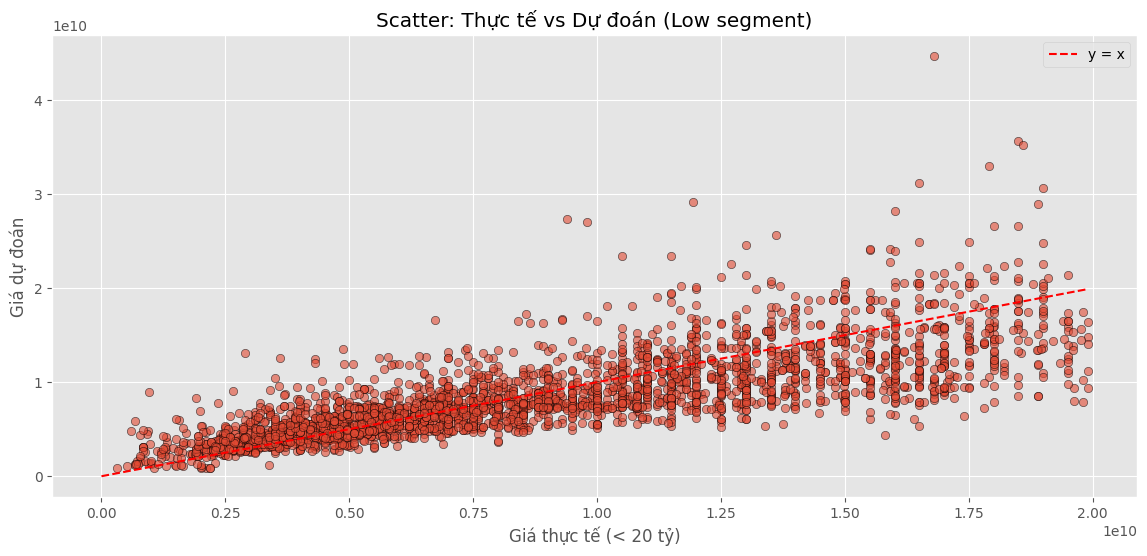

In [67]:
# === LOW segment ===
# Dự đoán lại trên toàn bộ dữ liệu < 20 tỷ
X_low_scaled = scaler_low.transform(X_lowLn)
y_pred_low_log = model_low.predict(X_low_scaled)
y_pred_low = np.expm1(y_pred_low_log)

plt.figure(figsize=(14,6))
plt.scatter(y_lowLn, y_pred_low, alpha=0.6, edgecolor='k')
plt.plot([0, max(y_lowLn)], [0, max(y_lowLn)], 'r--', label="y = x")
plt.xlabel("Giá thực tế (< 20 tỷ)")
plt.ylabel("Giá dự đoán")
plt.title("Scatter: Thực tế vs Dự đoán (Low segment)")
plt.legend()
plt.show()

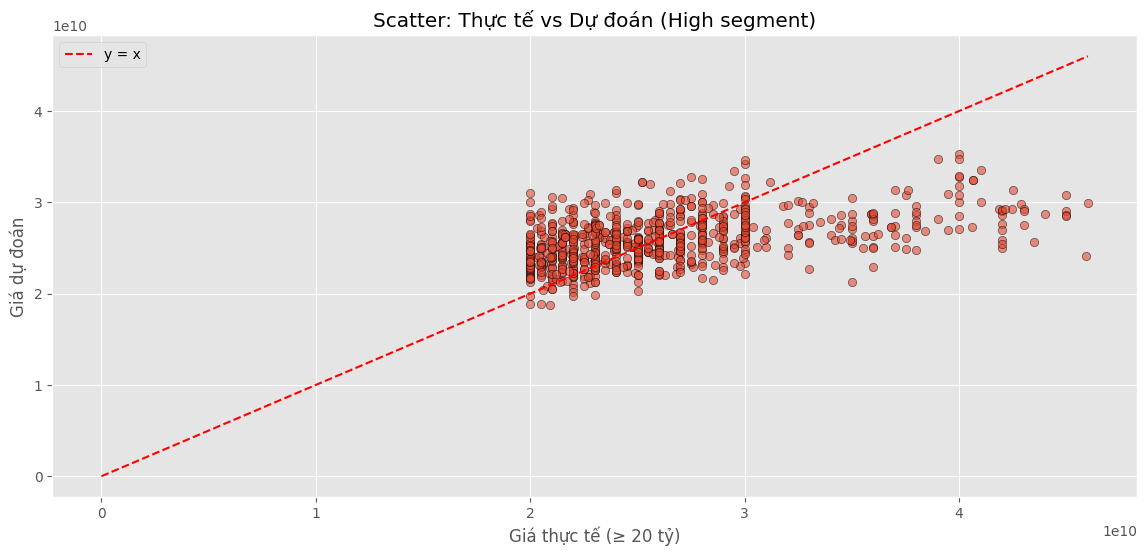

In [66]:
X_high_scaled = scaler_high.transform(X_highLn)
y_pred_high_log = model_high.predict(X_high_scaled)
y_pred_high = np.expm1(y_pred_high_log)

plt.figure(figsize=(14,6))
plt.scatter(y_highLn, y_pred_high, alpha=0.6, edgecolor='k')
plt.plot([0, max(y_highLn)], [0, max(y_highLn)], 'r--', label="y = x")
plt.xlabel("Giá thực tế (≥ 20 tỷ)")
plt.ylabel("Giá dự đoán")
plt.title("Scatter: Thực tế vs Dự đoán (High segment)")
plt.legend()
plt.show()

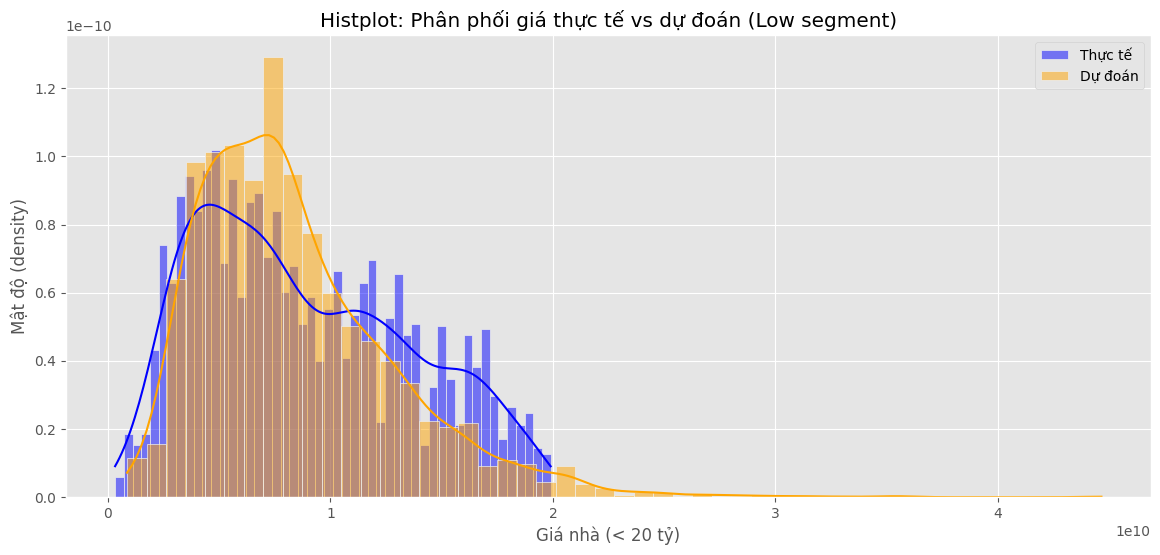

In [65]:
plt.figure(figsize=(14,6))
sns.histplot(y_lowLn, bins=50, color="blue", label="Thực tế", kde=True, stat="density", alpha=0.5)
sns.histplot(y_pred_low, bins=50, color="orange", label="Dự đoán", kde=True, stat="density", alpha=0.5)
plt.xlabel("Giá nhà (< 20 tỷ)")
plt.ylabel("Mật độ (density)")
plt.title("Histplot: Phân phối giá thực tế vs dự đoán (Low segment)")
plt.legend()
plt.show()

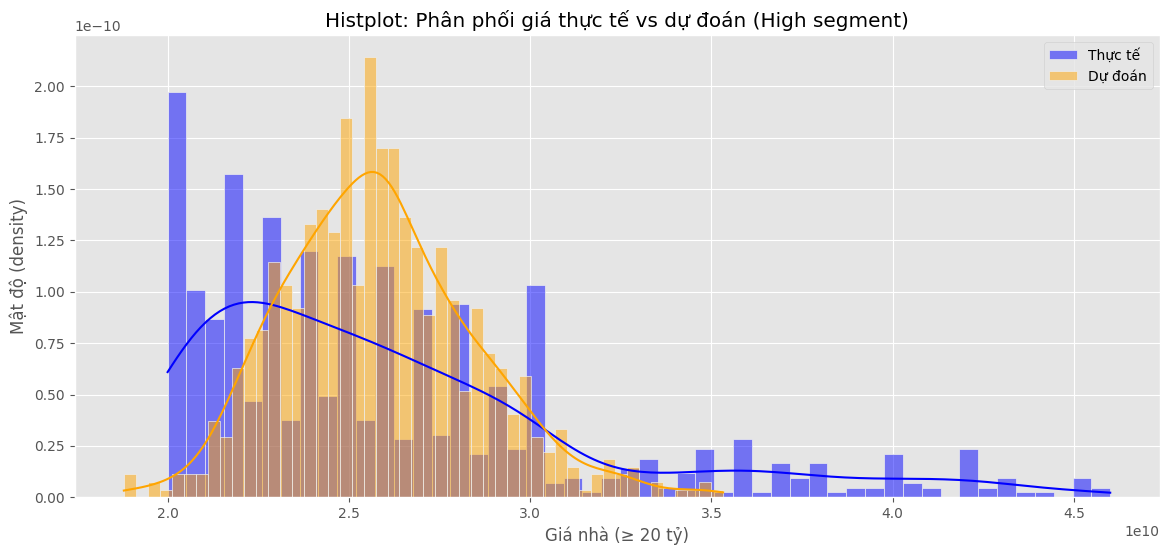

In [68]:
X_high_scaled = scaler_high.transform(X_highLn)
y_pred_high_log = model_high.predict(X_high_scaled)
y_pred_high = np.expm1(y_pred_high_log)
plt.figure(figsize=(14,6))
sns.histplot(y_highLn, bins=50, color="blue", label="Thực tế", kde=True, stat="density", alpha=0.5)
sns.histplot(y_pred_high, bins=50, color="orange", label="Dự đoán", kde=True, stat="density", alpha=0.5)
plt.xlabel("Giá nhà (≥ 20 tỷ)")
plt.ylabel("Mật độ (density)")
plt.title("Histplot: Phân phối giá thực tế vs dự đoán (High segment)")
plt.legend()
plt.show()

# V. So sánh độ chính xác của 2 mô hình

In [ ]:
Model LOW (<20 tỷ): {'MAE': 875396386.0092455, 'RMSE': 1276298735.5449953, 'R2': 0.9291066297684121}
📊 Model HIGH (≥20 tỷ): {'MAE': 1867947729.058747, 'RMSE': 2755939860.3019853, 'R2': 0.7536371737562944}


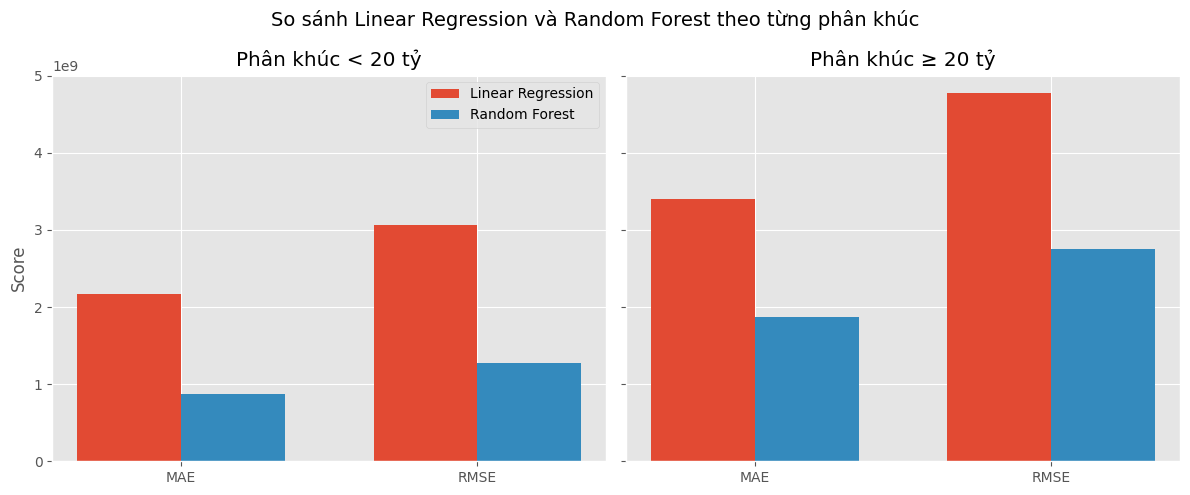

In [69]:
metrics = ["MAE", "RMSE"]

# Kết quả cho phân khúc <20 tỷ (Low segment)
linear_low = [2166503272.5450554,3060244821.7282014]
rf_low     = [875396386.0092455,1276298735.5449953]

# Kết quả cho phân khúc ≥20 tỷ (High segment)
linear_high = [3406633023.208744, 4773130591.503862]
rf_high     = [1867947729.058747, 2755939860.3019853]

x = np.arange(len(metrics))
width = 0.35

fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# --- Phân khúc <20 tỷ ---
axes[0].bar(x - width/2, linear_low, width, label='Linear Regression')
axes[0].bar(x + width/2, rf_low, width, label='Random Forest')
axes[0].set_title("Phân khúc < 20 tỷ")
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel("Score")
axes[0].legend()

# --- Phân khúc ≥20 tỷ ---
axes[1].bar(x - width/2, linear_high, width, label='Linear Regression')
axes[1].bar(x + width/2, rf_high, width, label='Random Forest')
axes[1].set_title("Phân khúc ≥ 20 tỷ")
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)

fig.suptitle("So sánh Linear Regression và Random Forest theo từng phân khúc", fontsize=14)
plt.tight_layout()
plt.show()

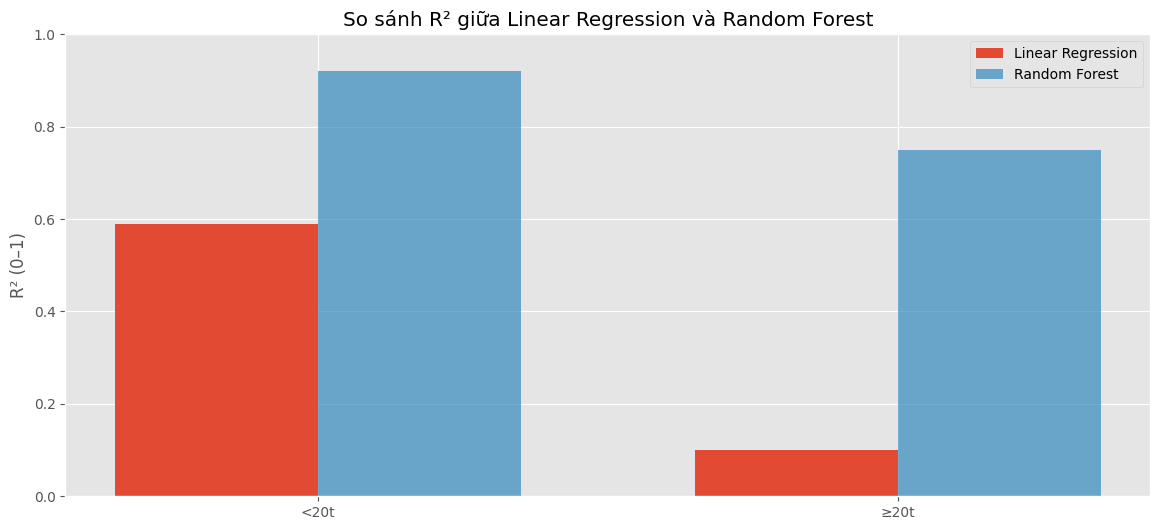

In [70]:
labels = ["<20t", "≥20t"]
x = np.arange(len(labels))
width = 0.35

# R² values
linear_r2 = [0.59, 0.1]
rf_r2     = [0.92, 0.75]

fig, ax = plt.subplots(figsize=(14,6))

# Linear Regression (alpha=1)
ax.bar(x - width/2, linear_r2, width, label="Linear Regression", alpha=1)

# Random Forest (alpha=0.7 để phân biệt)
ax.bar(x + width/2, rf_r2, width, label="Random Forest", alpha=0.7)

ax.set_ylabel("R² (0–1)")
ax.set_title("So sánh R² giữa Linear Regression và Random Forest")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0,1)
ax.legend()

plt.show()